In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
from scipy import stats
# import carbon_utils
# import PyCO2SYS as pyco2
from tabulate import tabulate
from io import StringIO  # for creating a string buffer to store the table
from multiprocessing import Pool
import functions.pressure_level_glodap_mean as pl
# from datetime import datetime
import functions.plot_offsets_crossover_plot_only as plot_gdap
import time
import functions.outlier_filter_ESD_test as outlier


### Set up paths

In [2]:
adjustment=False
# glodap_offsets_filename = 'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4.nc'
# glodap_offsets_filename = 'glodap_offsets_100km_2_to_50_50m_0.1dens_0.1spice_5.nc'
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]

if adjustment is True:
    argo_path = argo_path + '../Corrected/Sprof/'

# Set the paths
# for deep o2 manuscript:
output_dir = argo_path + '../output_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14/'
# output_dir = argo_path + '../output_100km_1400_to_2100_100m_0.005dens_0.005spice_LIPHR_14/'

# output_dir = argo_path + '../output_50km_1_to_50_25m_0.05dens_0.05spice_ESPER_14/'
output_dir = argo_path + '../output_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14/'
# output_dir = argo_path + '../output_100km_400_to_2100_100m_0.005dens_0.005spice_ESPER_14/'

data_dir = 'data/'

# Check for a glodap_offsets_plots directory, create if it does not exist
offset_dir = output_dir + 'glodap_offset_plots/'
if not os.path.isdir(offset_dir):
    os.mkdir(offset_dir)
# if not os.path.isdir(grouped_plot_dir):
#     os.mkdir(grouped_plot_dir)


# inputs that will not normally change
var_list_plot = ['PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED','DOXY_ADJUSTED','NITRATE_ADJUSTED',
                    'DIC','pH_25C_TOTAL_ADJUSTED','PH_IN_SITU_TOTAL_ADJUSTED','PDENS']


### Identify files, pressure levels, float age bins

In [3]:
# user inputs
# calculate trimmed means at different pressure levels for listed files
grouped_plot_dir = offset_dir + '2024_10_22/'
# grouped_plot_dir = offset_dir + '2024_09_25/'

# todays_date = datetime.today().strftime('%Y_%m_%d')
# grouped_plot_dir = offset_dir + 'grouped_plots/' + todays_date + '/'

# grouped_plot_dir = offset_dir + 'grouped_plots/levels_mean_saved/'

if not os.path.isdir(grouped_plot_dir):
    os.mkdir(grouped_plot_dir)

# for manuscript:
glodap_offsets_filenames = ['glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']

# glodap_offsets_filenames = ['glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005_spice_7.nc']
# glodap_offsets_filenames = ['glodap_offsets_100km_1_to_550_50m_0.05dens_0.05spice_6.nc', 'glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_6.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_550_50m_0.05dens_0.05_spice_7.nc', 'glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005_spice_7.nc']
# glodap_offsets_filenames = ['glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_LIPHR_7.nc']
# glodap_offsets_filenames = ['output_50km_1_to_550_50m_0.05dens_0.05spice_ESPER_14.nc', 'glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_550_50m_0.05dens_0.05spice_ESPER_14.nc','glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']
# glodap_offsets_filenames = ['glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_50_25m_0.05dens_0.05spice_ESPER_14.nc']
# glodap_offsets_filenames = ['glodap_offsets_50km_1_to_500_25m_0.05dens_0.05spice_ESPER_14.nc','glodap_offsets_100km_400_to_2100_100m_0.005dens_0.005spice_ESPER_14.nc']

pressure_levels = [1500, 2000]  # Adjust as needed
# pressure_levels = [0, 100, 200, 300, 400, 500, 750, 1000, 1250, 1500, 2000]  # Adjust as needed
# pressure_levels = [1500, 2000]  # Adjust as needed
# pressure_levels = [1, 50]  # Adjust as needed

# pressure_levels = [1500, 1700, 2000]  # Adjust as needed

year_filt = 0
year_plus_minus = 5

# bin edges in days to calculat mean offset as it evolves over the float/optode's age
# float_age_bins = [0, 365/2, 365, 365*2, 365*3, 365*7]
# float_age_bins = [0, 365, 365*7]
float_age_bins = [0, 365*10]



### prepare the list of arguments to pass to pressure_level_filter


In [4]:
glodap_offsets = []
delay_between_starts = 5  # number of seconds for each additional instance to wait, may help with a memory bottleneck 

for filename in glodap_offsets_filenames:
        ds = xr.load_dataset(argo_path + '../output_' + filename[15:-3] + '/' +filename)
        # ds = xr.load_dataset(output_dir+filename)
        glodap_offsets.append(ds)

gdap_mean_args = []
for idx, gdap_offsets_n in enumerate(glodap_offsets):
        time_delay = 0
        gdap_offsets_n_temp = gdap_offsets_n.copy()
        for j in range(len(pressure_levels) - 1):
                # only add to the processing list if the pressure level is in the correct range for a given file, otherwise skip 
                if np.logical_and(np.nanmin(gdap_offsets_n_temp.PRES_ADJUSTED_float)<= pressure_levels[j+1], np.nanmax(gdap_offsets_n_temp.PRES_ADJUSTED_float)>= pressure_levels[j]):
                        print(idx)
                        print(pressure_levels[j])
                        time_delay = time_delay+ delay_between_starts
                        gdap_mean_args_n = [(argo_path,grouped_plot_dir,
                                glodap_offsets_filenames[idx][0:-3],
                                gdap_offsets_n_temp, 
                                var_list_plot,year_filt,pressure_levels[j],
                                pressure_levels[j+1],year_plus_minus,time_delay, float_age_bins) ]
                        gdap_mean_args.extend(gdap_mean_args_n)
                # break   
        # break
print(len(gdap_mean_args))

0
1500
1


### run pressure level filter for all files, all pressures 


In [24]:
num_processes = 18 # number of cpus to use 

if __name__ == "__main__":
    
    with Pool(processes=num_processes) as pool:
        # Use pool.starmap with the list of arguments
        pool.starmap(pl.pressure_level_filter, gdap_mean_args)

H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 1
1
H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/op

0 out of 186
1 out of 186
2 out of 186
3 out of 186
4 out of 186
5 out of 186
6 out of 186
7 out of 186
8 out of 186
9 out of 186
10 out of 186
11 out of 186
12 out of 186
13 out of 186
14 out of 186
15 out of 186
16 out of 186
17 out of 186
18 out of 186
19 out of 186
20 out of 186
21 out of 186
22 out of 186
23 out of 186
24 out of 186
25 out of 186
26 out of 186
27 out of 186
28 out of 186
29 out of 186
30 out of 186
31 out of 186
32 out of 186
33 out of 186
34 out of 186
35 out of 186
36 out of 186
37 out of 186
38 out of 186
39 out of 186
40 out of 186
41 out of 186
42 out of 186
43 out of 186
44 out of 186
45 out of 186
46 out of 186
47 out of 186
48 out of 186
49 out of 186
50 out of 186
51 out of 186
52 out of 186
53 out of 186
54 out of 186
55 out of 186
56 out of 186
57 out of 186
58 out of 186
59 out of 186
60 out of 186
61 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


62 out of 186
63 out of 186
64 out of 186
65 out of 186
66 out of 186
67 out of 186
68 out of 186
69 out of 186
70 out of 186
71 out of 186
72 out of 186
73 out of 186
74 out of 186
75 out of 186
76 out of 186
77 out of 186
78 out of 186
79 out of 186
80 out of 186
81 out of 186
82 out of 186
83 out of 186
84 out of 186
85 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


86 out of 186
87 out of 186
88 out of 186
89 out of 186
90 out of 186
91 out of 186
92 out of 186
93 out of 186
94 out of 186
95 out of 186
96 out of 186
97 out of 186
98 out of 186
99 out of 186
100 out of 186
101 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


102 out of 186
103 out of 186
104 out of 186
105 out of 186
106 out of 186
107 out of 186
108 out of 186
109 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


110 out of 186
111 out of 186
112 out of 186
113 out of 186
114 out of 186
115 out of 186
116 out of 186
117 out of 186


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/xarray/coding/times.py:228: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


118 out of 186
119 out of 186
120 out of 186
121 out of 186
122 out of 186
123 out of 186
124 out of 186
125 out of 186
126 out of 186
127 out of 186
128 out of 186
129 out of 186
130 out of 186
131 out of 186
132 out of 186
133 out of 186
134 out of 186
135 out of 186
136 out of 186
137 out of 186
138 out of 186
139 out of 186
140 out of 186
141 out of 186
142 out of 186
143 out of 186
144 out of 186
145 out of 186
146 out of 186
147 out of 186
148 out of 186
149 out of 186
150 out of 186
151 out of 186
152 out of 186
153 out of 186
154 out of 186
155 out of 186
156 out of 186
157 out of 186
158 out of 186
159 out of 186
160 out of 186
161 out of 186
162 out of 186
163 out of 186
164 out of 186
165 out of 186
166 out of 186
167 out of 186
168 out of 186
169 out of 186
170 out of 186
171 out of 186
172 out of 186
173 out of 186
174 out of 186
175 out of 186
176 out of 186
177 out of 186
178 out of 186
179 out of 186
180 out of 186
181 out of 186
multiple cal comments
6903575
182 out of

### Take netcdf output of crossovers and load all into gdap_offsets and mean_gdap_offsets

In [4]:
# put all .nc files into grouped arrays 


mean_gdap_offsets = {}
gdap_offsets = {}
# load .nc files saved out for pressure levels
for idx, filename in enumerate(glodap_offsets_filenames):

        trimmed_means = {}
        # variables with offsets that you want to trim

        gdap_offsets_file = {}
        for j in range(len(pressure_levels) - 1):
                pressure_level_min = pressure_levels[j]
                nc_filename_mean = grouped_plot_dir+filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                        'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'
                
                
                try:
                        ds = xr.load_dataset(nc_filename_mean)
                except:
                        continue
                trimmed_means[f'level_{pressure_levels[j]}'] = ds
                
                nc_filename_all = grouped_plot_dir+filename[0:-3]+ '_all_offsets_depth_grouped_' + \
                                        'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'
                all_offsets_ds = xr.load_dataset(nc_filename_all)
                gdap_offsets_file[f'level_{pressure_levels[j]}'] = all_offsets_ds
                # break
        mean_gdap_offsets[glodap_offsets_filenames[idx]]=trimmed_means
        gdap_offsets[glodap_offsets_filenames[idx]]=gdap_offsets_file
        # break


### Plot individual crossover plots

In [7]:
# For making individual plots
from importlib import reload

parallel_on = True
reload(plot_gdap)
num_processes = 18 # number of cpus to use 

# make individual glodap crossover plots for each pressure level
# filename = 'glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005_spice_7.nc'
for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):
        pressure_level_min = pressure_levels[j]
        pressure_level_max = pressure_levels[j+1]

        # single_level_offsets = gdap_offsets[filename]['level_1500']
        try:
            single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
            mean_level_offsets = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']

        except:
            continue
        individual_plot_dir = grouped_plot_dir+filename[0:-3]+ '_all_offsets_depth_grouped_' + \
                                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + \
                                                    '_level_' + str(pressure_level_min) + '_individual_floats/'
        if not os.path.isdir(individual_plot_dir):
            os.mkdir(individual_plot_dir)
            
        offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)
        print(individual_plot_dir)
        
        if parallel_on is False:
            if 'checklist' not in locals():
                unique_labels = list(offsets_g.groups.keys())
                checklist = [False] * len(unique_labels)

            print(unique_labels)
        
            for n, g in offsets_g:
                
                index_to_check = unique_labels.index(n)

                # print(checklist[index_to_check])
                if not checklist[index_to_check]:
                    plot_gdap.plot_glodap_crossovers(individual_plot_dir,
                                mean_level_offsets,
                                g, [pressure_level_min, pressure_level_max], float_age_bins)
                    
                    # Find the index of the label in unique_labels
                    index_to_mark_off = unique_labels.index(n)
                    
                    # Mark off the corresponding position in the checklist
                    checklist[index_to_mark_off] = True
                    break
        else:
            if __name__ == "__main__":
                
                with Pool(processes=num_processes) as pool:
                    # Create a list of arguments for pool.starmap
                    gdap_cross_plot_args = [(individual_plot_dir,
                            mean_level_offsets,
                            g, [pressure_level_min, pressure_level_max], float_age_bins) for n, g in offsets_g]
                    # print('Here')
                    # Use pool.starmap with the list of arguments
                    pool.starmap(plot_gdap.plot_glodap_crossovers, gdap_cross_plot_args)
        # break



/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Datasets/Data_Products/BGC_ARGO_GLOBAL/2024_10_22_GBC_R1/Sprof/../output_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14/glodap_offset_plots/2024_10_22/glodap_offsets_100km_1400_to_2100_100m_0.005dens_0.005spice_ESPER_14_all_offsets_depth_grouped_year_filt_0_5_level_1500_individual_floats/
Plotting crossover for: 1900650
Plotting crossover for: 1902382
Plotting crossover for: 1901217
Plotting crossover for: 1901158
Plotting crossover for: 2900124
Plotting crossover for: 2902274
Plotting crossover for: 2903455
Plotting crossover for: 3900533
Plotting crossover for: 2903648
Plotting crossover for: 2903863
Plotting crossover for: 4900482
Plotting crossover for: 3902463
Plotting crossover for: 4900882
Plotting crossover for: 4903744
6.346006917928149
-0.0001291321622065624
Plotting crossover for: 5900966
Plotting crossover for: 5901072
-3.8052796406761225
6.257254231028603e-05
0.8407014612965105
-0.00046773149622083155
-2.2121618281194677
0.0

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 2900127
Plotting crossover for: 1901206
-3.805467795221634
0.00012656162395313492
Plotting crossover for: 1901339
Plotting crossover for: 2903651
-1.4761214005689527
-0.00016701480917712707
Plotting crossover for: 5901339
-1.9945294010158316
0.0002804656313567095
Plotting crossover for: 5901187
Plotting crossover for: 3902554
Plotting crossover for: 3901669
-5.373711775079384
0.0003095981629742326
-6.4708768468488
0.0003181495728484419
Plotting crossover for: 5901045
Plotting crossover for: 5901452
-0.8515577028029837
-8.798255502536002e-05
Plotting crossover for: 4900485
-2.3159640219473303
0.0002484110291150939
Plotting crossover for: 4901140
-7.638258177622425
0.00034952439897188264
Plotting crossover for: 2902294
7.992634737884872
-0.0002756770906534652
Plotting crossover for: 5900245
Plotting crossover for: 1902651
Plotting crossover for: 3900275
3.0798590702230197
3.140138612235553e-05
Plotting crossover for: 1900943
-11.042499806780347
-1.2289625629261214

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 5901048
102.69110680835644
-0.01256000084246912
Plotting crossover for: 3902123
Plotting crossover for: 4901801
-3.6295885584342074
0.00012219547386807807
-10.424830146159193
0.00022983939811946675
Plotting crossover for: 5901455
-3.126344314248378
-4.0443061746255806e-05
Plotting crossover for: 5901311
Plotting crossover for: 4900497
-9.999238368095124
0.00022467701593595425
-17.3334048728323
0.0007093402593353458
Plotting crossover for: 5900421
-6.032513230233839
2.6604665635272627e-05
Plotting crossover for: 2903472
Plotting crossover for: 2900117
Plotting crossover for: 2902297
1.8259931382097188
5.680506551593365e-05
Plotting crossover for: 3900334
6.305865474121918
-0.00026709114684509886
Plotting crossover for: 1901152
-0.28107773781076695
0.0002691011187633216
Plotting crossover for: 1901363
-5.141193171925365
0.00033032656637263784
Plotting crossover for: 2902092
Plotting crossover for: 1901210
-5.934698608795971
9.761688333479714e-05
-3.359094395105745

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 1901154
2.9110764314526336
0.00019593340682385306
Plotting crossover for: 2902270
-0.9199954933096081
-7.594535876384666e-06
Plotting crossover for: 1901365
2.7757880292909247
-0.00047719158727149556
Plotting crossover for: 4900480
Plotting crossover for: 5901052
1.542109334080553
0.0001549666465653549
2.570837734427335
-2.6070767498134843e-05
Plotting crossover for: 3900347
6.843180190173042
-0.0004502317696350086
Plotting crossover for: 1901212
-3.3061601028659955
-6.328478239712884e-05
Plotting crossover for: 5901445
Plotting crossover for: 2903656
6.102862951808945
0.0006573141688004291
-3.6488801335329533
5.0730726192037504e-05
Plotting crossover for: 4903500
0.5284731212563166
-0.00012456694528124662
Plotting crossover for: 3902129
Plotting crossover for: 5901461
-1.501423659752647
-0.00016112166305161184
Plotting crossover for: 2903354
Plotting crossover for: 5900965
Plotting crossover for: 2900120
-4.81526955633685
0.0002186549089638608
-2.38458836956417

/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/code_for_GBC/functions/plot_offsets_crossover_plot_only.py:61: RankWarning: Polyfit may be poorly conditioned
  m1, b1 = np.polyfit(mdates.date2num(g_ox.main_float_juld),g_ox.DOXY_ADJUSTED_offset_trimmed, 1)


Plotting crossover for: 4900872
-4.7813747192216285
0.00027471129526965315
Plotting crossover for: 1901155
2.4171714368275765
7.523666686096899e-05
Plotting crossover for: 2902271
-12.003098478447352
0.0008957333694998377
Plotting crossover for: 1902303
1.3711915023433134
-0.00012568630842983925
Plotting crossover for: 4900481
-1.9655124501304788
0.0002830162024182877
Plotting crossover for: 5901069
-2.394341162106392
0.00016643205235436595
Plotting crossover for: 3900348
-0.06215542547094488
-0.0002290650402702538
Plotting crossover for: 2903614
Plotting crossover for: 1901213
-1.1090957224617617
1.955982669574201e-05
Plotting crossover for: 3902131
-8.57652721684848
0.0003135865423836986
Plotting crossover for: 5901446
Plotting crossover for: 4903591
-1.8994052386160725
0.0002902262240598272


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 5901462
124.77094923955467
-0.015154092635022938
Plotting crossover for: 2903657
-5.247064465869181
0.00012377145989667392
Plotting crossover for: 2903451
-3.113024304758078
-4.285561478030985e-06
Plotting crossover for: 2900123
-6.004803094584147
0.0005874561306678353
Plotting crossover for: 5901316
Plotting crossover for: 5901491
-1.408767901872451
-9.286055183916374e-05
-0.23696917902236958
0.0003048967044431025
Plotting crossover for: 4900873
Plotting crossover for: 2902272
8.648888926851448
-0.0002398993457093964
Plotting crossover for: 1902304
Plotting crossover for: 1901156
8.647131995549682
-0.00019977389464207197
1.437091783141011
4.5229226146059e-05
Plotting crossover for: 5901735
-0.9516743281604381
0.0002993518010696797
Plotting crossover for: 5901071
-4.801405350332951
0.00018971432196888055
Plotting crossover for: 1901214
-3.718010868715541
4.031394171183489e-05
Plotting crossover for: 3900532
Plotting crossover for: 4903624
-2.857689009155332
-5.4

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


-2.6191142889576335
0.0001225421854604985
Plotting crossover for: 5905986
-5.637672761683081
0.00016616457330548645
Plotting crossover for: 5906498
-4.223796137489725
0.00011832364967442497
Plotting crossover for: 5906236
-112.99488384382511
0.014149798282827083
Plotting crossover for: 5906296
10.643494620982779
-0.0009011067870498282
Plotting crossover for: 5905099
-7.356233093831916
0.00020111167508144988
Plotting crossover for: 5906004
Plotting crossover for: 5906204
Plotting crossover for: 5906487
Plotting crossover for: 5905378
-3.4249777832192456
9.193166592334908e-05
0.5808088816247493
-5.7069619649144975e-05
Plotting crossover for: 5906471
Plotting crossover for: 5905970
Plotting crossover for: 5905142
-1.308532854519175
-8.101683332464357e-05
-8.086189737932255
0.00016704870968903753
1.5271851218061019
-4.822366858355193e-05
Plotting crossover for: 5904093
-3.83851661945168
0.00014773030648701266
Plotting crossover for: 5906033
-6.14070143158594
0.00042961011299292933
Plotting

/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/code_for_GBC/functions/plot_offsets_crossover_plot_only.py:61: RankWarning: Polyfit may be poorly conditioned
  m1, b1 = np.polyfit(mdates.date2num(g_ox.main_float_juld),g_ox.DOXY_ADJUSTED_offset_trimmed, 1)


Plotting crossover for: 5906238
-0.843461967714388
6.26215213446618e-05
Plotting crossover for: 5906489
-7.236555371782925
0.0002567298811142736
Plotting crossover for: 5906519
2.3491097865863324
-0.00013734973768691656
Plotting crossover for: 5906006
Plotting crossover for: 5906207
-1.3436458422531832
-0.00012144329825699198
Plotting crossover for: 5905991
Plotting crossover for: 5905381
Plotting crossover for: 5906473
-2.909696027318223
-1.9904040374944583e-05
-3.713174471172527
0.00016217016094919985
0.44918334931319914
-0.00020902596324406432
Plotting crossover for: 5906314
Plotting crossover for: 5905972
-2.7844678682502644
6.704299012147736e-05
3.7229604793448887
-0.0005766388802670211
Plotting crossover for: 5905366
Plotting crossover for: 5905113
-2.5614136675273125
2.5937574462763626e-05
Plotting crossover for: 5906220
Plotting crossover for: 5906035
-5.032052404812675
0.0002679461924573101
Plotting crossover for: 5906437
Plotting crossover for: 5906502
2.643927455944612
0.000

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 5906523
Plotting crossover for: 5906479
-0.3710454951352036
-0.00017052059295846845
Plotting crossover for: 5905132
-9.653549265212812
0.0009881957650862514
-2.7668707331130498
8.474169389049051e-05
Plotting crossover for: 5906225
No non-nan DOXY offsets
Plotting crossover for: 5906226
-1.2887684838353426
-6.723394462651168e-05
Plotting crossover for: 5905442
No non-nan DOXY offsets
Plotting crossover for: 5905635
Plotting crossover for: 5906318
Plotting crossover for: 5905995
-2.1468434116642117
-8.376940632014474e-05
-4.6652987058172775
-0.00010792726269328179
-2.5645612964569913
9.965591502751724e-05
Plotting crossover for: 5905977
-4.661942311723332
0.00011388866004510812
Plotting crossover for: 5906537
Plotting crossover for: 5906043
Plotting crossover for: 5906510
914.0402666615585
-0.11665302231884912
-6.381820994266993
0.0005385061713285107
Plotting crossover for: 5906441
-8.800635869034418
0.0005850031542459193
Plotting crossover for: 5906247
-4.2870232

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


-23.6129597167016
0.0005326957099984996
-2.988944406876683
-9.29057113395612e-06
-1.9506098589871037
8.117760846386001e-05
Plotting crossover for: 6990583
Plotting crossover for: 6901601
-5.51490693552202
0.0004083995110939959
Plotting crossover for: 5906541
Plotting crossover for: 6900530
No non-nan DOXY offsets
Plotting crossover for: 6900531
No non-nan DOXY offsets
Plotting crossover for: 6900627
-6.327992070185568
0.0005064917639613493
Plotting crossover for: 6902734
Plotting crossover for: 6903026
Plotting crossover for: 6901755
-4.0223047703482235
0.00020727649802930405
Plotting crossover for: 5906531
Plotting crossover for: 5906559
Plotting crossover for: 6901023
Plotting crossover for: 5906580
-3.9460147967084485
0.0002554367071726237
-3.8971344058238038
5.8784217289636586e-05
-13.966379223671733
0.0008695631235227828
Plotting crossover for: 6902808
-3.688402988371262
0.0001429693179891109
Plotting crossover for: 6903568
-10.748340152509932
0.00033729267147440147
Plotting cross

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 5906560
7.499260734598952
-0.0002473005724415449
-4.264669235248968
9.055773975143398e-06
Plotting crossover for: 5906533
Plotting crossover for: 6990585
No non-nan DOXY offsets
Plotting crossover for: 6990587
No non-nan DOXY offsets
Plotting crossover for: 7900566
1.787224608535148
-0.00010469553903973154
Plotting crossover for: 6903569
-8.1137265620202
9.414442620543016e-05
Plotting crossover for: 5906516
Plotting crossover for: 6902810
-0.4256451252879647
-4.377782294315082e-05
Plotting crossover for: 6901024
-10.268188641510957
0.0003333818127057613
Plotting crossover for: 6901465
No non-nan DOXY offsets
Plotting crossover for: 6901466
Plotting crossover for: 6903589


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 6901603
Plotting crossover for: 5906544
Plotting crossover for: 6903549
Plotting crossover for: 6902736
-12.629357040409655
-4.973706921176317e-05
Plotting crossover for: 6900629
1.6856044397193686
-0.0003980100602296169
Plotting crossover for: 5906583
Plotting crossover for: 6901758
-4.403062112718547
0.0003090861452787858
Plotting crossover for: 5906561
-3.4847291708962906
-8.561824249262176e-05
Plotting crossover for: 6902811
-3.1808787851537197
0.0001713469830374605
Plotting crossover for: 6903570
Plotting crossover for: 7901006
Plotting crossover for: 6901468
-1.1231595550646998
-0.00023684113603529756
-24.37508775415523
0.0008464540379341231
-0.6761639698281403
0.0003219815159518683
Plotting crossover for: 6903590
Plotting crossover for: 6901025
-5.129823492182152
-4.083847240603346e-05
-5.351791350424872
0.0001960465388316378
Plotting crossover for: 6901627
-5.727596708342179
0.0003540674168654126
Plotting crossover for: 5906545
Plotting crossover for: 69

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 6903550
-4.076790346300429
-0.0002742431716353039
Plotting crossover for: 5906765
-4.574686351523732
0.000324800162987976
Plotting crossover for: 6900630
-6.3069000342566
-0.0002618721444933307
Plotting crossover for: 6901759
Plotting crossover for: 5906562
-6.257289404389045
0.000259156070595443
-5.8413201129595915
0.00018470373588525942
Plotting crossover for: 6901476
Plotting crossover for: 6903571
Plotting crossover for: 7901095
-38.65557356726478
0.0012768523420141958
Plotting crossover for: 6902818
-4.308073623054851
6.907133646857089e-05
0.9873847987222824
-8.712210601413252e-06
Plotting crossover for: 6903591
-17.094879942877533
0.00037722023795115005
Plotting crossover for: 6901026
-3.9113554528801764
8.274666652726721e-05
Plotting crossover for: 5906546
Plotting crossover for: 6901628
Plotting crossover for: 6902739
No non-nan DOXY offsets
Plotting crossover for: 6902740
-12.21291259222621
0.0004190705405775899
Plotting crossover for: 6903551
-36.45845

/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/code_for_GBC/functions/plot_offsets_crossover_plot_only.py:61: RankWarning: Polyfit may be poorly conditioned
  m1, b1 = np.polyfit(mdates.date2num(g_ox.main_float_juld),g_ox.DOXY_ADJUSTED_offset_trimmed, 1)


-68.37639237852949
0.003003969983278573
Plotting crossover for: 6902819
-8.950754856594086
0.0004948473517847858
Plotting crossover for: 7901098
Plotting crossover for: 6901027
-6.251400747601675
0.00018595174076325787
Plotting crossover for: 6901631
-0.5132812143912715
0.00016554581226771895
Plotting crossover for: 5906550
-3.776405239404453
7.491501218073686e-05
Plotting crossover for: 6902798
-11.081863483800227
0.00022870819409779946
Plotting crossover for: 6900896
-5.130544229724054
0.00025269796575327924
Plotting crossover for: 5907051
-0.5069497134332928
-0.00010642262981359092
Plotting crossover for: 6903552
-39.9127263811462
0.0015519480557965395
Plotting crossover for: 5906567
Plotting crossover for: 6901486
Plotting crossover for: 6901763
-2.0235769046850525
-0.00020117788968013143
-1.00971496474012
0.00012651808548695752
Plotting crossover for: 7901102
-0.20535467819523712
-0.00013615153574030758
Plotting crossover for: 6903822
No non-nan DOXY offsets
Plotting crossover for

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


-5.106544449663757
-1.8732546996289324e-06
Plotting crossover for: 6901523
Plotting crossover for: 6901764
No non-nan DOXY offsets
Plotting crossover for: 6901774
No non-nan DOXY offsets
Plotting crossover for: 6901775
-3553.7531241787424
0.235558284806842
Plotting crossover for: 7901103
Plotting crossover for: 6904111
8.823780441958439
-0.0007165688857471853
Plotting crossover for: 6903574
No non-nan DOXY offsets
Plotting crossover for: 6903575
-12.23583329461809
0.0003546126807618381
Plotting crossover for: 6902869
-9.056636037559704
0.0004193640033069837


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/code_for_GBC/functions/sokal_rohlf_calculations.py:63: RuntimeWarning: invalid value encountered in scalar divide
  r2 = s2_y_hat/s2_Y


Plotting crossover for: 6901646
-10.576096499149601
0.00040927551114946326
Plotting crossover for: 6901029
-5.363372408091417
0.0001482584165979537
Plotting crossover for: 6902802
-2.409589050721848
7.76747204672373e-05
Plotting crossover for: 6900953
6.7279188089494735
-7.395751830424322e-05
Plotting crossover for: 5906569
No non-nan DOXY offsets
Plotting crossover for: 5906570
-3.05592218972759
-0.00012394536831748437
Plotting crossover for: 5907054
Plotting crossover for: 6901593
-7.9972898412522
0.000248105758176766
Plotting crossover for: 6903554
Plotting crossover for: 6901933
-17.027661874680735
0.0006310968856334293
-4.9788018694051175
0.0001489975544035922
Plotting crossover for: 7901106
-29.01512839278523
0.005213939540868587
Plotting crossover for: 6904112
Plotting crossover for: 6903576
15.746321521051357
-0.0020493920541280043


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 6902871
Plotting crossover for: 6901750
-0.9395729516867174
9.868461908033484e-07
Plotting crossover for: 6901030
-8.272866203320918
0.0002800905110337041
Plotting crossover for: 6902803
Plotting crossover for: 6900954
3.8004768386975862
0.0002499919904302908


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 6901595
Plotting crossover for: 7901107
No non-nan DOXY offsets
-5.3986770529206005
0.00021311637279015268
Plotting crossover for: 6902686
-4.831954384117685
-1.743089328520472e-05
Plotting crossover for: 6904114
Plotting crossover for: 6903555
-46.65968173869432
0.0023859914933793093
Plotting crossover for: 6903577
-5.378150290884339
-0.0002909593901804237
Plotting crossover for: 6902880


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 6901751
-4.874698278253724
5.164054805429862e-05
Plotting crossover for: 6901151
No non-nan DOXY offsets
Plotting crossover for: 6901182
-2.9989762384066276
0.0002926843967205174
Plotting crossover for: 6902805
-7.359721211443883
0.00031208850815309986
Plotting crossover for: 6901596
Plotting crossover for: 6904115
-36.355437089206724
0.0022479822140458574
Plotting crossover for: 6902688
Plotting crossover for: 6903556


/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Plotting crossover for: 6902881
-0.8757040693054571
6.012208165733939e-05
Plotting crossover for: 6903578
Plotting crossover for: 6901752
-3.1638134639473914
0.00018288468863778654
Plotting crossover for: 6901183
Plotting crossover for: 6902806
2.9786792918419875
-0.00018977291586656992
Plotting crossover for: 6990582
Plotting crossover for: 6903557
-5494.026373616019
0.30447051425306204
Plotting crossover for: 6903579
-18.313792290451463
0.000591637622192335
Plotting crossover for: 6902882
-2.6245037407618046
0.00012597112586530123
Plotting crossover for: 6901753
-1.1681245407980456
5.009398114750918e-05
Plotting crossover for: 6903558
-18.68614326655934
0.0004244038896164213
Plotting crossover for: 6902900
No non-nan DOXY offsets


### Code below for testing, some output statistics

In [ ]:
##### test cell for pressure_level_glodap_mean

pressure_level_min = pressure_levels[j]
pressure_level_max = pressure_levels[j+1]

time.sleep(time_delay) 
# set all data not at that pressure level to nan                  
for var in var_list_plot:
    pressure_index = np.logical_and(gdap_offsets_n_temp['PRES_ADJUSTED_float']>pressure_level_min, 
                            gdap_offsets_n_temp['PRES_ADJUSTED_float']<=pressure_level_max)

    if year_filt==0:
        gdap_offsets_n_temp[var + '_float'] = gdap_offsets_n_temp[var + '_float'].where(pressure_index)
        gdap_offsets_n_temp[var + '_glodap'] = gdap_offsets_n_temp[var + '_glodap'].where(pressure_index)
        gdap_offsets_n_temp[var + '_offset'] = gdap_offsets_n_temp[var + '_offset'].where(pressure_index)
    elif year_filt==1:
        year_index = np.abs(gdap_offsets_n_temp.main_float_juld.dt.year-gdap_offsets_n_temp.glodap_datetime.dt.year)<=year_plus_minus
        gdap_offsets_n_temp[var + '_float'] = \
            gdap_offsets_n_temp[var + '_float'].where(np.logical_and(pressure_index, year_index))
        gdap_offsets_n_temp[var + '_glodap'] = \
            gdap_offsets_n_temp[var + '_glodap'].where(np.logical_and(pressure_index, year_index))
        gdap_offsets_n_temp[var + '_offset'] = \
            gdap_offsets_n_temp[var + '_offset'].where(np.logical_and(pressure_index, year_index))
        
# then group by wmo and proceed with DOXY_trimmed calculations
offsets_g = gdap_offsets_n_temp.groupby(gdap_offsets_n_temp.main_float_wmo)

if pressure_level_min<=400:
    # adding option to filter by time of year as well - for use in surface data
    time_filt = 1
    filt_days = 10
else:
    time_filt=0


# DOXY_ADJUSTED_offset_trimmed = []
# DOXY_ADJUSTED_offset_trimmed = []
# Create an empty data variable for DOXY offset trimmed with the same dimensions as N_CROSSOVERS
empty_data = np.empty(len(gdap_offsets_n_temp['N_CROSSOVERS']))
empty_data[:] = np.nan


# Create a new xarray DataArray with the empty data and the same coordinates
new_data_array = xr.DataArray(empty_data, coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']}, dims=['N_CROSSOVERS'])
gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed'] = new_data_array

for n,g in offsets_g:

    # run a GESD test using "test_num" number of possible outliers
    test_num = int((len(g.DOXY_ADJUSTED_offset.dropna(dim="N_CROSSOVERS", how="any").values)*.1)) # allowing for ~10 % to be outliers
    ESD_test_out = outlier.ESD_Test(g.DOXY_ADJUSTED_offset.dropna(dim="N_CROSSOVERS", how="any").values, 0.05, test_num, False, True)

    # only trim the data if deep, otherwise apply a day of year test but no other filtering 
    if time_filt==1:
        within_days = np.logical_or(np.abs(g.main_float_juld.dt.dayofyear - g.glodap_datetime.dt.dayofyear)<=filt_days, 
                        np.abs(g.main_float_juld.dt.dayofyear - g.glodap_datetime.dt.dayofyear)>(365-filt_days)) 
        temp_o2_offset = g.DOXY_ADJUSTED_offset.where(within_days)
    else:         # create temp_o2_offest to set all datapoints to nans that the GESD test says are outliers

        temp_o2_offset = g.DOXY_ADJUSTED_offset
        for a in range(0, ESD_test_out[1]):
            temp_o2_offset = temp_o2_offset.where(temp_o2_offset != ESD_test_out[2][a])

    # if there are too few points, set all to nans
    if temp_o2_offset.count()<20:
        temp_o2_offset[:] = np.nan

    # replace nan values with values of temp_o2_offset
    gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed'][gdap_offsets_n_temp['main_float_wmo']==[n]] = temp_o2_offset

    # append each temp_o2_offset to the new DOXY_ADJUSTED_offset_trimmed vector
    # DOXY_ADJUSTED_offset_trimmed.append(temp_o2_offset.values)
    #print(len(DOXY_ADJUSTED_offset_trimmed))
    break

# concatenate all vectors within DOXY_ADJUSTED_offset_trimmed (each represents one WMO)
# result_vector = np.concatenate(DOXY_ADJUSTED_offset_trimmed)
# # convert to Xarray DataArray
# result_da = xr.DataArray(result_vector, dims='N_CROSSOVERS', coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']})
# # add to glodap_offsets
# gdap_offsets_n_temp['DOXY_ADJUSTED_offset_trimmed']=result_da
# print(glodap_offsets)

# calculate mean DOXY_ADJUSTED_offsets for different day ranges
if len(float_age_bins)>0: # 0 = skip and do not apply
    print('in age section')
    # create new variables that will be the mean offsets for different time ranges
    empty_data = np.empty(len(gdap_offsets_n_temp['N_CROSSOVERS']))
    empty_data[:] = np.nan
    new_data_array = xr.DataArray(empty_data, coords={'N_CROSSOVERS': gdap_offsets_n_temp['N_CROSSOVERS']}, dims=['N_CROSSOVERS'])

    gdap_offsets_n_temp['First_Float_Profile_Date'] = new_data_array.copy()  # for storing the first date of first float profile

    for fa in range(len(float_age_bins)-1):
        gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])] = new_data_array.copy()
        gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa]) + '_count'] = new_data_array.copy()

    wmo_list = np.unique(gdap_offsets_n_temp.main_float_wmo)
    # loop through all floats
    for wmo_n in wmo_list:
        print(wmo_n)
        # load Sprof file, get date of first profile
        argo_n = xr.open_dataset(argo_path + str(wmo_n) + '_Sprof.nc')
        first_profile_date = argo_n.JULD[0].values

        gdap_offsets_n_temp['First_Float_Profile_Date'][gdap_offsets_n_temp.main_float_wmo==wmo_n] = first_profile_date

        # calculate offset time relative to first deployment
        time_since_first_ns = gdap_offsets_n_temp.main_float_juld[gdap_offsets_n_temp.main_float_wmo==wmo_n].values-first_profile_date
        time_since_first_days = time_since_first_ns / np.timedelta64(1, 'D')

        # save out o2 offsets for this float
        temp_o2_offset = gdap_offsets_n_temp.DOXY_ADJUSTED_offset[gdap_offsets_n_temp.main_float_wmo==wmo_n]


        # now loop through float_age_bins to calculate mean offsets for each age range 
        for fa in range(len(float_age_bins)-1):
            print(fa)
            # find ages within range
            age_index = np.logical_and(time_since_first_days>=float_age_bins[fa], time_since_first_days<float_age_bins[fa+1])

            # save the mean o2 offset where age_index is true to the correct age variable for that float
            if not np.all(np.isnan(temp_o2_offset.where(age_index).values)):
                gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])]\
                    [gdap_offsets_n_temp.main_float_wmo==wmo_n] = np.nanmean(temp_o2_offset.where(age_index).values)
            gdap_offsets_n_temp['DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa]) + '_count']\
                                [gdap_offsets_n_temp.main_float_wmo==wmo_n] = (temp_o2_offset.where(age_index).count())

        break



H0:  there are no outliers in the data
Ha:  there are up to 10 outliers in the data

Significance level:  α = 0.05
Critical region:  Reject H0 if Ri > critical value
Ri: Test statistic
λi: Critical Value
 
Number of outliers 0
0
in age section
1902303
0
1
2
3
4


In [32]:
# create a list to put in True / False if the glodap offsets intersect zero at float mid date

import matplotlib.dates as mdates
import functions.sokal_rohlf_calculations as SR
from scipy import interpolate

CI_confidence = 0.95

for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

        try:
            single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
            # mean_level_offsets = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']

        except:
            continue

        offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)
        glodap_drift_possible_list = []

        for n,g in offsets_g:
            g_ox = g.where(~np.isnan(g.DOXY_ADJUSTED_offset_trimmed), drop=True)
            if g_ox.dims['N_CROSSOVERS']!=0:

                g_ox_sorted = g_ox.sortby("glodap_datetime")
                
                X_series = pd.Series(mdates.date2num(g_ox_sorted.glodap_datetime))
                Y_series = pd.Series(g_ox_sorted.DOXY_ADJUSTED_offset_trimmed.values)

                if len(X_series)<5: # too short to realistically do a regression
                    uncert_min = np.nan
                    uncert_max = np.nan
                else:
                    # Y_series = pd.Series(g_ox_sorted.DOXY_ADJUSTED_offset_trimmed.values)
                    b_yx, a, r2, CI_confidence_slope, ttt, y_err = SR.regress_confidence_sokal_rohlf(X_series, Y_series, CI_confidence)

                    if not np.all(np.isnan(a)):

                        # extrapolate regression and CI if needed to intersect float_mid_date
                        # should apply the slope of the 
                        float_mid_date = mdates.date2num(g.main_float_juld.mean()) # mean float date in number

                        if np.max(X_series)<float_mid_date:
                            X_extend = X_series.append(pd.Series(float_mid_date))
                            y_extend = a+ X_extend*b_yx

                            X_series_last_third = X_series.iloc[np.int64(np.round(len(X_series)*1/2)):-1]
                            Y_err_last_third = y_err.iloc[np.int64(np.round(len(X_series)*1/2)):-1]

                            b_err, a_err, _, _, _, _ = SR.regress_confidence_sokal_rohlf(X_series_last_third, Y_err_last_third, CI_confidence)
                            extrap_error = X_extend.iloc[-1]*b_err+a_err
                            y_err_extend = y_err.append(pd.Series(extrap_error))

                            uncert_min = y_extend.iloc[-1] - y_err_extend.iloc[-1]
                            uncert_max = y_extend.iloc[-1] + y_err_extend.iloc[-1]
                        elif np.min(X_series)>float_mid_date:
                            X_extend = pd.Series(float_mid_date).append(X_series)
                            y_extend = a+ X_extend*b_yx
                            X_series_first_half = X_series.iloc[0:np.int64(np.round(len(X_series)*1/2))]
                            Y_err_first_half = y_err.iloc[1:np.int64(np.round(len(X_series)*1/2))]
                            b_err, a_err, _, _, _, _ = SR.regress_confidence_sokal_rohlf(X_series_last_third, Y_err_last_third, CI_confidence)
                            extrap_error = X_extend.iloc[0]*b_err+a_err
                            y_err_extend = pd.Series(extrap_error).append(y_err)

                #             plt.plot(X_extend, y_extend, color='blue', linestyle = '--')
                #             plt.fill_between(X_extend, y_extend-y_err_extend, y_extend+y_err_extend, color='blue', alpha=0.25)    
                            uncert_min = y_extend.iloc[0] - y_err_extend.iloc[0]
                            uncert_max = y_extend.iloc[0] + y_err_extend.iloc[0]
                        else:
                            y_float = float_mid_date*b_yx+a
                            f = interpolate.interp1d(X_series,y_err)
                            y_float_err = f(float_mid_date)

                            uncert_min = y_float - y_float_err
                            uncert_max = y_float + y_float_err
                    #         print(uncert_min)
                    #         print(uncert_max)

                        
                    if np.isnan(uncert_min):
                        glodap_drift_possible = np.nan
                    elif np.logical_and(uncert_min<0, uncert_max>0):
                        glodap_drift_possible = True
                    else:
                        glodap_drift_possible = False

                    glodap_drift_possible_list.append(glodap_drift_possible)



/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_33361/3221042849.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_extend = X_series.append(pd.Series(float_mid_date))
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_33361/3221042849.py:53: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_err_extend = y_err.append(pd.Series(extrap_error))
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_33361/3221042849.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_extend = X_series.append(pd.Series(float_mid_date))
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_33361/3221042849.py:53: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future v

In [33]:
# can drift explain offset?
count_true = 0
count_false = 0
for idx, TF in enumerate(glodap_drift_possible_list): 
    if TF is True: 
        count_true= count_true+1
    elif TF is False:
        count_false = count_false+1

print('True ' + str(count_true) + ' or ' + str((count_true/len(glodap_drift_possible_list)*100)))
print('False ' + str(count_false) + ' or ' + str((count_false/len(glodap_drift_possible_list)*100)))


True 82 or 12.424242424242424
False 571 or 86.51515151515152


In [35]:
# are oxygen offsets significantly different from zero?
significant=0
not_significant = 0
no_offset = 0
for n,g in offsets_g:
    #print("n:", n, "g:", g)
    g_plot = g.DOXY_ADJUSTED_offset_trimmed

    if np.all(np.isnan(g_plot)):
        no_offset = no_offset+1
        continue 
    g_mean = np.nanmean(g_plot.values)
    t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, nan_policy='omit') ############
    
    if  p_value<.05:
        significant = significant+1
    else:
        not_significant= not_significant + 1

print("number significant", significant)
print("number not significant", not_significant)

print('number where no offset could be calculated: ' + str(no_offset))
print('Total offsets: ' + str(len(offsets_g)))

number significant 615
number not significant 45
number where no offset could be calculated: 210
Total offsets: 870


In [10]:
for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

        try:
            single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
            # mean_level_offsets = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']

        except:
            continue

        offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)
        


In [ ]:
single_level_offsets['p_compare_min'][0].item()

In [11]:
# Depth dependency of offsets:
# 1. Bin by depth - 50m bins? 100m bins?
# 2. Save a dataframe with wmo, depth, o2 conc, o2 offset, o2 offset minus mean o2 offset
# That should give you what you need to plot all float offsets vs. depth and concentration
press_bin_width = 10
press_bins = np.linspace(np.int32(single_level_offsets['p_compare_min'][0].item()), 
                   np.int32(single_level_offsets['p_compare_max'][0].item()), press_bin_width)

press_response_all_df = pd.DataFrame(columns=['wmo','avg_depth','o2_conc', 'o2_offset', 'o2_offset_minus_mean'])
num_count = 0
for n,g in offsets_g:
    num_count = num_count+1    
    print(str(n)+ ' ' + str(num_count))
    g_ox = g.where(~np.isnan(g.DOXY_ADJUSTED_offset_trimmed), drop=True)

    # loop through press_bins, finding pressures that fit and averaging everything
    press_response_data = []  # List to store data

    for idx in range(0, len(press_bins)-1):
        depth_index = np.logical_and(g_ox['PRES_ADJUSTED_float']>=press_bins[idx], 
                                     g_ox['PRES_ADJUSTED_float']<press_bins[idx+1])
        if sum(depth_index)==0:
            continue

        # make a new dataframe for this pressure bin

        press_response_data.append({
                    'wmo': np.int32(g_ox['main_float_wmo'][0].item()),
                    'avg_depth': np.mean(g_ox['PRES_ADJUSTED_float'][depth_index]).values.tolist(),
                    'o2_conc': np.mean(g_ox['DOXY_ADJUSTED_float'][depth_index]).values.tolist(),
                    'o2_offset': np.mean(g_ox['DOXY_ADJUSTED_offset_trimmed'][depth_index]).values.tolist(),
                    'o2_offset_minus_mean': (np.mean(g_ox['DOXY_ADJUSTED_offset_trimmed'][depth_index]).values - \
                                             np.mean(g_ox['DOXY_ADJUSTED_offset_trimmed']).values).tolist()

            })
    # Convert the list of dictionaries into a DataFrame
    press_response_df = pd.DataFrame(press_response_data)
    # concatenate dataframes
    press_response_all_df = pd.concat([press_response_all_df, press_response_df], ignore_index=True)


1900722 1
1900943 2
1901134 3
1901135 4
1901152 5
1901153 6
1901154 7
1901155 8
1901156 9
1901157 10
1901158 11
1901159 12
1901205 13
1901206 14
1901208 15
1901209 16
1901210 17
1901211 18
1901212 19
1901213 20
1901214 21
1901215 22
1901217 23
1901218 24
1901338 25
1901339 26
1901348 27
1901360 28
1901361 29
1901362 30
1901363 31
1901364 32
1901365 33
1901378 34
1901379 35
2900114 36
2900115 37
2900116 38
2900117 39
2900118 40
2900119 41
2900120 42
2900123 43
2900124 44
2900125 45
2900126 46
2900127 47
2900128 48
2900129 49
2902090 50
2902091 51
2902092 52
2902093 53
3900333 54
3900334 55
3900344 56
3900346 57
3900347 58
3900348 59
3900515 60
3900516 61
3900521 62
3900523 63
3900524 64
3900715 65
3900728 66
3900729 67
3900791 68
3900792 69
3900793 70
3901065 71
3901066 72
3901067 73
3901068 74
3901075 75
3901076 76
3901077 77
3901078 78
3901079 79
3901080 80
3901081 81
3901082 82
3901084 83
3901496 84
3901497 85
3901498 86
3901530 87
3901531 88
3901668 89
3901669 90
3902120 91
3902121 

KeyboardInterrupt: 

In [ ]:
press_response_all_df

In [ ]:


# +
plt.subplot(1,2,1)
plt.plot(press_response_all_df['o2_offset_minus_mean'], press_response_all_df['avg_depth'], 'x')
plt.xlim([-20, 20])
plt.grid()
plt.ylim([2050, 1450])

plt.subplot(1,2,2)
plt.plot(press_response_all_df['o2_offset_minus_mean'], press_response_all_df['o2_conc'], 'x')
plt.xlim([-5, 5])
plt.grid()
# plt.ylim([2050, 1450])

In [ ]:
print(hist.statistic.shape)
print(offset_bins[0:-1].shape)
print(o2_bins[0:-1].shape)
print(offset_mesh.T.shape)
print(o2_mesh.T.shape)

In [ ]:
o2_bins = np.arange(0, 350, 5)
offset_bins = np.arange(-10, 10, 0.5)
hist = stats.binned_statistic_2d(press_response_all_df['o2_offset_minus_mean'], press_response_all_df['o2_conc'], None, bins=[offset_bins, o2_bins], statistic="count")

hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
hist.statistic


offset_mesh, o2_mesh = np.meshgrid(offset_bins, o2_bins)



image = plt.pcolormesh(offset_mesh.T, o2_mesh.T, hist.statistic, shading="flat")

# Add colorbar and labels if needed
plt.colorbar(label="Count")
plt.xlabel("Offset")
plt.ylabel("Oxygen Concentration")
plt.grid()
plt.clim(0,50)

In [ ]:
if np.all(np.isnan(g_plot)):
    no_offset = no_offset+1

In [ ]:
single_level_offsets = gdap_offsets[filename][f'level_{pressure_levels[j]}']
offsets_g = single_level_offsets.groupby(single_level_offsets.main_float_wmo)


In [ ]:
j=0
pressure_level_min = pressure_levels[j]
nc_filename_mean = filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

nc_filename_mean
glodap_offsets_mean = xr.load_dataset(grouped_plot_dir + nc_filename_mean)


In [ ]:
temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']/glodap_offsets_mean['DOXY_ADJUSTED_glodap']*100
temp_var.mean()

+---------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
|               |   count |   mean |   std |     p_value |   95.0% CI low |   95.0% CI high |   median |   min |   max |
+===============+=========+========+=======+=============+================+=================+==========+=======+=======+
| All           |     660 |   -1.9 |   3.9 | 8.37232e-34 |           -2.2 |            -1.6 |     -1.9 | -18.1 |  15   |
+---------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| No air cal.   |     305 |   -1   |   3.9 | 2.5107e-05  |           -1.4 |            -0.5 |     -0.9 | -18.1 |  11   |
+---------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| Air cal.      |     307 |   -3   |   3.4 | 1.05831e-41 |           -3.4 |            -2.7 |     -2.7 | -17.8 |   7.7 |
+---------------+---------+-----

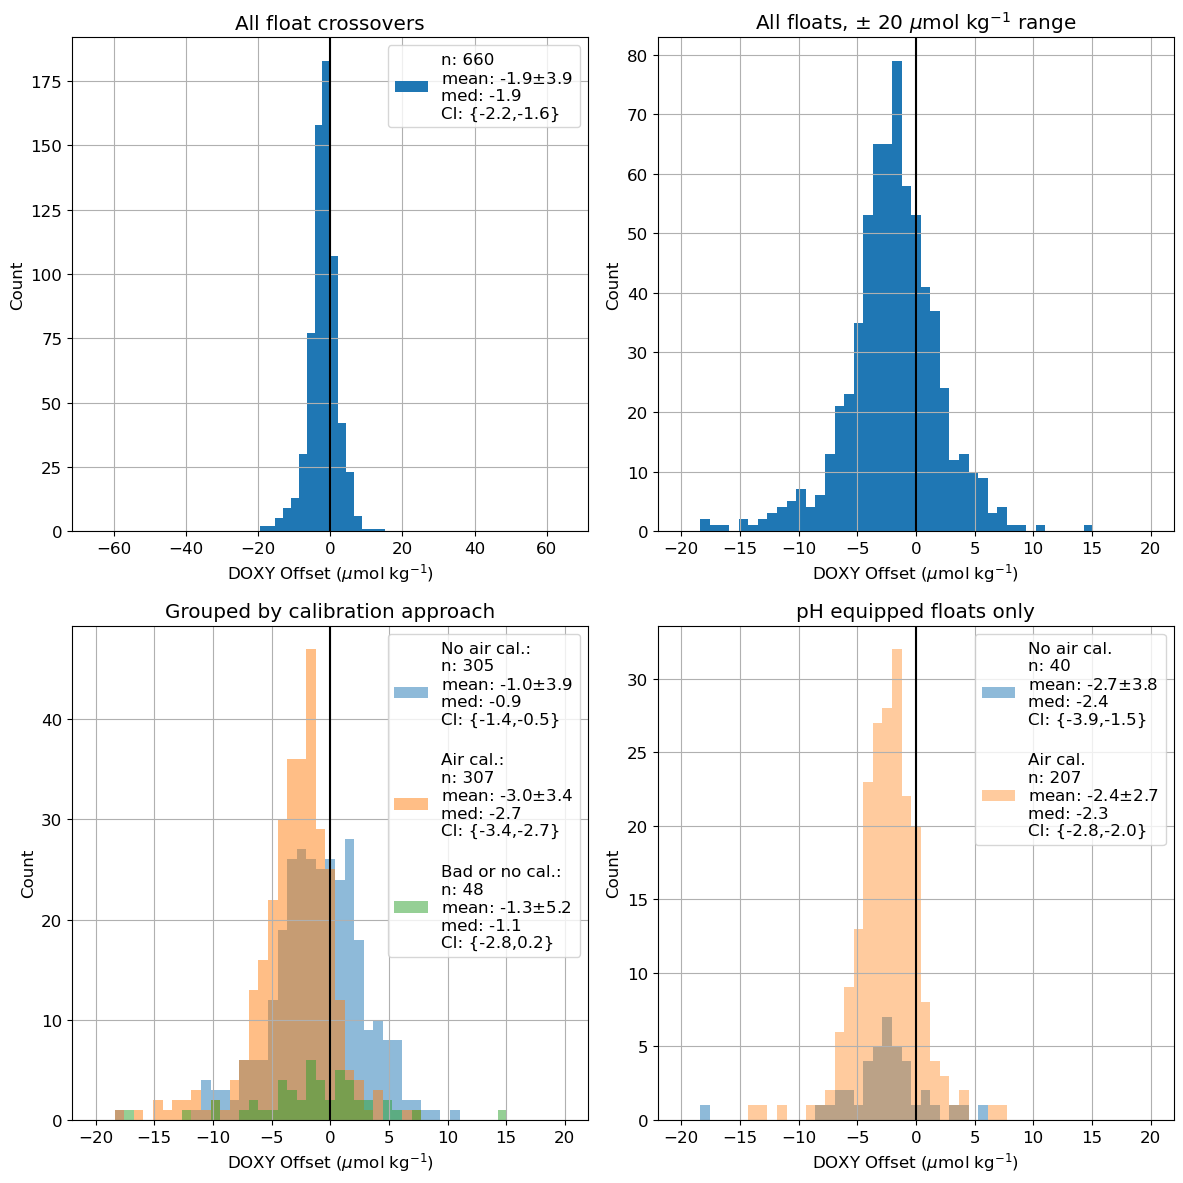

In [9]:
# Plotting histograms 
year_filt = 0
x_val = 0 # offset in umol / kg
# x_val = 1 # offset in % 

for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

        pressure_level_min = pressure_levels[j]
        nc_filename_mean = filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

        # nc_filename_all = filename[0:-3]+ '_all_offsets_depth_grouped_' + \
        #                         'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

        # if ~os.path.exists(grouped_plot_dir + nc_filename_mean):
        #     continue
        # load files and fix longitude
        # histogram plot for each file / pressure level
        if 'glodap_offsets_mean' in locals():
                del glodap_offsets_mean
        try:
                glodap_offsets_mean = xr.load_dataset(grouped_plot_dir + nc_filename_mean)
        except:
                continue
        
                # don't need to fix longitude in this section of code
        # float_wmo_list = glodap_offsets_p.index.values
        # float_wmo_list = glodap_offsets_mean.main_float_wmo.values
        # if 'glodap_offsets' in locals():
        #     del glodap_offsets


        # glodap_offsets = xr.load_dataset(grouped_plot_dir + nc_filename_all)

        # # loop through mean array
        # for n in range(0,float_wmo_list.shape[0]):
        #         wmo_n = float_wmo_list[n]

        #         # fix long_n mean biases:
        #         temp_LONGITUDE = glodap_offsets.main_float_longitude.where(glodap_offsets.main_float_wmo==wmo_n, drop=True)

        #         if (np.max(temp_LONGITUDE) - np.min(temp_LONGITUDE))>300:
        #                 # print(n)
        #                 new_mean = np.mean(xr.where(temp_LONGITUDE>=0, temp_LONGITUDE, temp_LONGITUDE+360))
        #                 if new_mean>180:
        #                         new_mean = new_mean-360
                                
        #                 old_mean = np.mean(glodap_offsets.main_float_longitude.where(glodap_offsets.main_float_wmo==wmo_n, drop=True))
        #                 # print('old mean: '  + str(old_mean.values))
        #                 # print('orig mean glodap:' + str(glodap_offsets_mean['main_float_longitude'].loc[{'main_float_wmo': wmo_n}].values))

        #                 # print('new mean: '  + str(new_mean.values))

        #                 # put new LONGITUDE into long_n
        #                 glodap_offsets_mean['main_float_longitude'].loc[{'main_float_wmo': wmo_n}] = new_mean.values
        #                 # print('New mean glodap:' + str(glodap_offsets_mean['main_float_longitude'].loc[{'main_float_wmo': wmo_n}].values))

        glodap_offsets_p = glodap_offsets_mean.to_dataframe()


        parameter_a = 'o2_calib_air_group'
        parameter_b = 'pH_group'
        offsets_g = glodap_offsets_p.groupby(parameter_a)
        offsets_pH = glodap_offsets_p.groupby([parameter_a, parameter_b])
        CI_level = 0.95
        plt.rcParams.update({'font.size': 12})

        plt.figure(figsize=(12,12))

        #All Float Crossovers
        plt.subplot(2,2,1)
        if x_val==0:
                temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']
                x_label = r'DOXY Offset ($\mu$mol kg$^{-1}$)'
        elif x_val==1:
                temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']/glodap_offsets_mean['DOXY_ADJUSTED_glodap']*100
                x_label = 'DOXY Offset (%)'

        ncount = temp_var.count()
        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)

        o2_offset_data_table = [('All', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax)]
        plt.hist(temp_var, 
                bins=np.linspace(-65, 65, 61), label='n: '+str(ncount.values) +  '\nmean: ' + str(nmean.values) + '$\pm$' + str(nstd.values) + '\nmed: ' + str(nmedian.values) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}'
                ) # ,label=str(n)
        #print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].median().values, decimals=1))
        plt.grid()
        plt.title('All float crossovers')
        plt.xlabel(x_label)
        plt.ylabel('Count')
        plt.axvline(x=0, color='k')
        plt.legend()

        # All float crossovers, zoomed in
        plt.subplot(2,2,2)
        plt.title('All floats, $\pm$ 20 $\mu$mol kg$^{-1}$ range')

        plt.hist(temp_var, 
                bins=np.linspace(-20, 20, 50),label='median='+str(nmedian.values) + 
                ', n='+str(ncount.values)) # ,label=str(n)
        plt.grid()
        plt.ylabel('Count')
        plt.axvline(x=0, color='k')

        plt.xlabel(x_label)

        # Split into calibration group
        plt.subplot(2,2,3)
        No_air_cal_all = offsets_g.get_group('no air cal')
        if x_val==0:
                temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']/No_air_cal_all['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count() # only counts non-nan values
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('No air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))


        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='No air cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')



        air_cal_all = offsets_g.get_group('air cal')
        if x_val==0:
                temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']/air_cal_all['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count() # only counts non-nan values
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)

        o2_offset_data_table.append(('Air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))


        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='Air cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')


        no_cal_all = offsets_g.get_group('no cal/bad')
        if x_val==0:
                temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']/no_cal_all['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count() # only counts non-nan values
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('No cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='Bad or no cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}')



        #for n, group in offsets_g:
        #    print(n)
        #    nmean = np.around(group['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
        #    nmedian = np.around(group['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
        #    ncount = group['DOXY_ADJUSTED_offset_trimmed'].count()

            

        plt.title('Grouped by calibration approach')

        plt.axvline(x=0, color='k')
        plt.grid()
        plt.xlabel(x_label)
        plt.ylabel('Count')

        plt.legend()

        # pH equipped floats only 
        plt.subplot(2,2,4)
        plt.title('pH equipped floats only')

        no_air_cal_ph = offsets_pH.get_group(('no air cal', 'pH'))
        if x_val==0:
                temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']/no_air_cal_ph['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        nstd = np.around(temp_var.std(), decimals=1)
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        ncount = temp_var.count()

        # temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('pH - No cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.5,label='No air cal. \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')

        air_cal_ph = offsets_pH.get_group(('air cal', 'pH'))
        if x_val==0:
                temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        elif x_val==1:
                temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']/air_cal_ph['DOXY_ADJUSTED_glodap']*100

        nmean = np.around(temp_var.mean(), decimals=1)
        nmedian = np.around(temp_var.median(), decimals=1)
        ncount = temp_var.count()
        nstd = np.around(temp_var.std(), decimals=1)
        nmin = np.around(temp_var.min(), decimals=1)
        nmax = np.around(temp_var.max(), decimals=1)

        # temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
        t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

        CI_vals = stats.norm.interval(confidence=CI_level, 
                        loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                        scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
        CI_low = np.around(CI_vals[0], decimals=1)
        CI_high = np.around(CI_vals[1], decimals=1)
        o2_offset_data_table.append(('pH - Air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

        plt.hist(temp_var, bins=np.linspace(-20, 20, 50),
                    alpha=0.4,label='Air cal. \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + '\nmed: ' + str(nmedian) +
                '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}')


        #for n, group in offsets_pH:
        #    if n[1] == 'no pH' or n[0] == 'no cal/bad':
        #        continue
        #    print(n)
        #    nmean = np.around(group['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
        #    nmedian = np.around(group['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
        #    ncount = group['DOXY_ADJUSTED_offset_trimmed'].count()

        plt.xlabel(x_label)
        plt.ylabel('Count')
        plt.axvline(x=0, color='k')

        plt.legend()
            
        plt.tight_layout()
        plt.grid()

        if x_val==0:
                plot_filename = nc_filename_mean
        elif x_val==1:
                plot_filename = nc_filename_mean + '_offset_percent'

        plt.savefig(grouped_plot_dir + plot_filename + '_histogram.png', dpi=300)

        print(tabulate(o2_offset_data_table, headers=['count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))
        

+-----------------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
|                       |   count |   mean |   std |     p_value |   95.0% CI low |   95.0% CI high |   median |   min |   max |
+=======================+=========+========+=======+=============+================+=================+==========+=======+=======+
| NITRATE_ADJUSTED      |     330 |    0.2 |   0.4 | 6.71923e-15 |           0.14 |            0.22 |      0.2 |  -2.3 |   1.8 |
+-----------------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| pH_25C_TOTAL_ADJUSTED |     137 |   -5.6 |   7.5 | 8.79363e-15 |          -6.85 |           -4.34 |     -4.5 | -40   |  14.1 |
+-----------------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| DIC                   |     188 |    3.6 |   7   | 6.4636e-11  |           2.56 |            4.

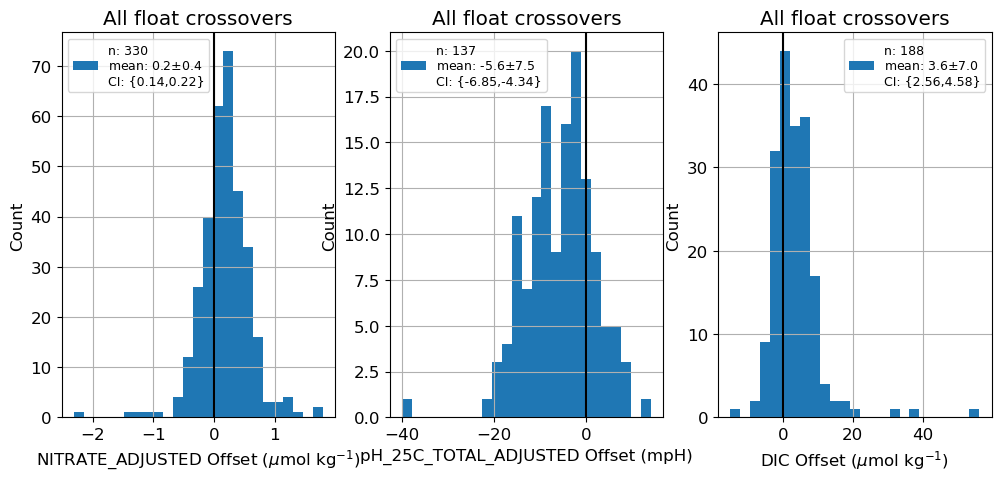

In [10]:
## plot nitrate, pH, DIC offsets for each file / grouping 
CI_level = 0.95
var_plot = ['NITRATE_ADJUSTED','pH_25C_TOTAL_ADJUSTED', 'DIC']

# Plotting histograms 
year_filt = 0
x_val = 0 # offset in umol / kg

for idx, filename in enumerate(glodap_offsets_filenames):
    for j in range(len(pressure_levels) - 1):

                pressure_level_min = pressure_levels[j]
                nc_filename_mean = filename[0:-3]+ '_floatmean_withcalibration_depth_grouped_' + \
                                'year_filt_' + str(year_filt) +'_' + str(year_plus_minus) + '_level_' + str(pressure_level_min) + '.nc'

                if 'glodap_offsets_mean' in locals():
                    del glodap_offsets_mean
                try:
                        glodap_offsets_mean = xr.load_dataset(grouped_plot_dir + nc_filename_mean)
                except:
                        continue
                
                # plt.rcParams.update({'font.size': 12})
                o2_offset_data_table = []
               
                plt.figure(figsize=(12,5))

                for v, var in enumerate(var_plot):
                    if np.logical_or(var=='PH_IN_SITU_TOTAL_ADJUSTED', var=='pH_25C_TOTAL_ADJUSTED'):
                        scale = 1000
                        x_label_units = '(mpH)'
                    else:
                        scale = 1
                        x_label_units = '($\mu$mol kg$^{-1}$)'
                    #All Float Crossovers
                    plt.subplot(1,3,v+1)
                    ncount = glodap_offsets_mean[var_plot[v] + '_offset'].count().values
                    nmean = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].mean().values*scale, decimals=1)
                    nstd = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].std().values*scale, decimals=1)
                    nmedian = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].median().values*scale, decimals=1)
                    nmin = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].min().values*scale, decimals=1)
                    nmax = np.around(glodap_offsets_mean[var_plot[v] + '_offset'].max().values*scale, decimals=1)

                    temp_var = glodap_offsets_mean[var_plot[v] + '_offset']*scale
                    t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

                    CI_vals = stats.norm.interval(confidence=CI_level, 
                                    loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                                    scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
                    CI_low = np.around(CI_vals[0], decimals=2)
                    CI_high = np.around(CI_vals[1], decimals=2)
                    o2_offset_data_table.append([var_plot[v], 
                                                ncount, 
                                                nmean, 
                                                nstd, 
                                                p_value, CI_low, CI_high, nmedian, nmin, nmax])
                    plt.hist(glodap_offsets_mean[var_plot[v] + '_offset']*scale, 
                            label='n: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + 
                        '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}',bins=25) # ,label=str(n) #bins=np.linspace(-65, 65, 61),
                    #print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].median().values, decimals=1))
                    plt.grid()
                    plt.title('All float crossovers')
                    plt.xlabel(var_plot[v] + ' Offset ' + x_label_units)
                    plt.ylabel('Count')
                    plt.axvline(x=0, color='k')
                    plt.legend(fontsize=9)
                plt.tight_layout

                plot_filename = nc_filename_mean

                plt.savefig(grouped_plot_dir + plot_filename + '_no3_pH_dic_histogram.png', dpi=300)

                print(tabulate(o2_offset_data_table, headers=['count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))


In [ ]:
mean_gdap_offsets

### Setting group names for projects, sensor types, data centers, etc.

In [5]:
# Assuming 'project_name' is the variable in your xarray dataset
dataset_n = mean_gdap_offsets[filename]['level_1500']
project_name_values = dataset_n['project_name'].values
big_projects = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(project_name_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=10:
        big_projects.append(group_name)

print(big_projects)

Group Name:                                                                 , Count: 14
Group Name: AMOP                                                            , Count: 2
Group Name: ARGO GEOMAR                                                     , Count: 2
Group Name: ARGO Italy                                                      , Count: 1
Group Name: ARGO Norway                                                     , Count: 4
Group Name: ARGO-BSH                                                        , Count: 2
Group Name: ARGO_SPAIN                                                      , Count: 1
Group Name: Argo Australia, Count: 1
Group Name: Argo Australia                                                  , Count: 56
Group Name: Argo Canada                                                     , Count: 14
Group Name: Argo GERMANY                                                    , Count: 1
Group Name: Argo INDIA                                                      , Count: 15
Gr

In [6]:
dataset_n = mean_gdap_offsets[filename]['level_1500']
data_center_values = dataset_n['data_centre'].values
data_centers = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(data_center_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=5:
        data_centers.append(group_name)

print(data_centers)

Group Name: AO, Count: 582
Group Name: BO, Count: 4
Group Name: CS, Count: 57
Group Name: IF, Count: 183
Group Name: IN, Count: 17
Group Name: JA, Count: 13
Group Name: ME, Count: 14
['AO', 'CS', 'IF', 'IN', 'JA', 'ME']


In [7]:
dataset_n = mean_gdap_offsets[filename]['level_1500']
o2_sensor_values = dataset_n['DOXY_sensor'].values
o2_sensors = []
# Get unique values and their counts
unique_groups, group_counts = np.unique(o2_sensor_values, return_counts=True)

# Display the group names and counts
for group_name, count in zip(unique_groups, group_counts):
    print(f"Group Name: {group_name}, Count: {count}")
    
    if count>=1:
        o2_sensors.append(group_name)

print(o2_sensors)

Group Name: 3830                                                                                                                                                                                                                                                            , Count: 1
Group Name: AANDERAA_OPTODE_3830                                                                                                                                                                                                                                            , Count: 139
Group Name: AANDERAA_OPTODE_4330                                                                                                                                                                                                                                            , Count: 550
Group Name: ARO_FT                                                                                                                                             

In [ ]:
np.mean([float_age_bins[fa], float_age_bins[fa+1]])

In [8]:
dataset_n

<xarray.Dataset>
Dimensions:                           (main_float_wmo: 870)
Coordinates:
  * main_float_wmo                    (main_float_wmo) object '1900650' ... '...
Data variables: (12/64)
    p_compare_min                     (main_float_wmo) float64 1.4e+03 ... 1....
    p_compare_max                     (main_float_wmo) float64 2.1e+03 ... 2....
    delta_dens                        (main_float_wmo) float64 0.005 ... 0.005
    delta_spice                       (main_float_wmo) float64 0.005 ... 0.005
    delta_press                       (main_float_wmo) float64 100.0 ... 100.0
    dist                              (main_float_wmo) float64 100.0 ... 100.0
    ...                                ...
    pH_sensor                         (main_float_wmo) object 'none' ... 'ISU...
    nitrate_group                     (main_float_wmo) object 'no nitrate' .....
    nitrate_sensor                    (main_float_wmo) object 'none' ... 'ISU...
    DOXY_group                        (main_float_wmo) object 'DOXY' ... 'DOXY'
    DOXY_sensor                       (main_float_wmo) object 'AANDERAA_OPTOD...
    ice_group                         (main_float_wmo) object 'no ice' ... 'n...

In [9]:
dataset_n.where(abs(dataset_n['main_float_latitude'])<60)
dataset_n

<xarray.Dataset>
Dimensions:                           (main_float_wmo: 870)
Coordinates:
  * main_float_wmo                    (main_float_wmo) object '1900650' ... '...
Data variables: (12/64)
    p_compare_min                     (main_float_wmo) float64 1.4e+03 ... 1....
    p_compare_max                     (main_float_wmo) float64 2.1e+03 ... 2....
    delta_dens                        (main_float_wmo) float64 0.005 ... 0.005
    delta_spice                       (main_float_wmo) float64 0.005 ... 0.005
    delta_press                       (main_float_wmo) float64 100.0 ... 100.0
    dist                              (main_float_wmo) float64 100.0 ... 100.0
    ...                                ...
    pH_sensor                         (main_float_wmo) object 'none' ... 'ISU...
    nitrate_group                     (main_float_wmo) object 'no nitrate' .....
    nitrate_sensor                    (main_float_wmo) object 'none' ... 'ISU...
    DOXY_group                        (main_float_wmo) object 'DOXY' ... 'DOXY'
    DOXY_sensor                       (main_float_wmo) object 'AANDERAA_OPTOD...
    ice_group                         (main_float_wmo) object 'no ice' ... 'n...

In [38]:
temp_dataset.keys()

Index(['p_compare_min', 'p_compare_max', 'delta_dens', 'delta_spice',
       'delta_press', 'dist', 'PRES_ADJUSTED_offset', 'PRES_ADJUSTED_glodap',
       'PRES_ADJUSTED_float', 'TEMP_ADJUSTED_offset', 'TEMP_ADJUSTED_glodap',
       'TEMP_ADJUSTED_float', 'PSAL_ADJUSTED_offset', 'PSAL_ADJUSTED_glodap',
       'PSAL_ADJUSTED_float', 'DOXY_ADJUSTED_offset', 'DOXY_ADJUSTED_glodap',
       'DOXY_ADJUSTED_float', 'NITRATE_ADJUSTED_offset',
       'NITRATE_ADJUSTED_glodap', 'NITRATE_ADJUSTED_float', 'DIC_offset',
       'DIC_glodap', 'DIC_float', 'pH_25C_TOTAL_ADJUSTED_offset',
       'pH_25C_TOTAL_ADJUSTED_glodap', 'pH_25C_TOTAL_ADJUSTED_float',
       'PH_IN_SITU_TOTAL_ADJUSTED_offset', 'PH_IN_SITU_TOTAL_ADJUSTED_glodap',
       'PH_IN_SITU_TOTAL_ADJUSTED_float', 'PDENS_offset', 'PDENS_glodap',
       'PDENS_float', 'pH_25C_T_P1500_offset', 'pH_25C_T_P1500_glodap',
       'pH_25C_T_P1500_float', 'main_float_profile', 'main_float_longitude',
       'glodap_longitude', 'main_float_latitude',

In [43]:

data_mag_p = temp_dataset['DOXY_ADJUSTED_float'].copy()


main_float_wmo
1900722         NaN
1900943         NaN
1901134    0.095811
1901135    1.942910
1901152         NaN
             ...   
6902881         NaN
6903180         NaN
6903197         NaN
6903204         NaN
6903222         NaN
Length: 429, dtype: float64

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_11031/1858151242.py:97: RuntimeWarning: Mean of empty slice
  loc=np.nanmean(temp_var[~np.i

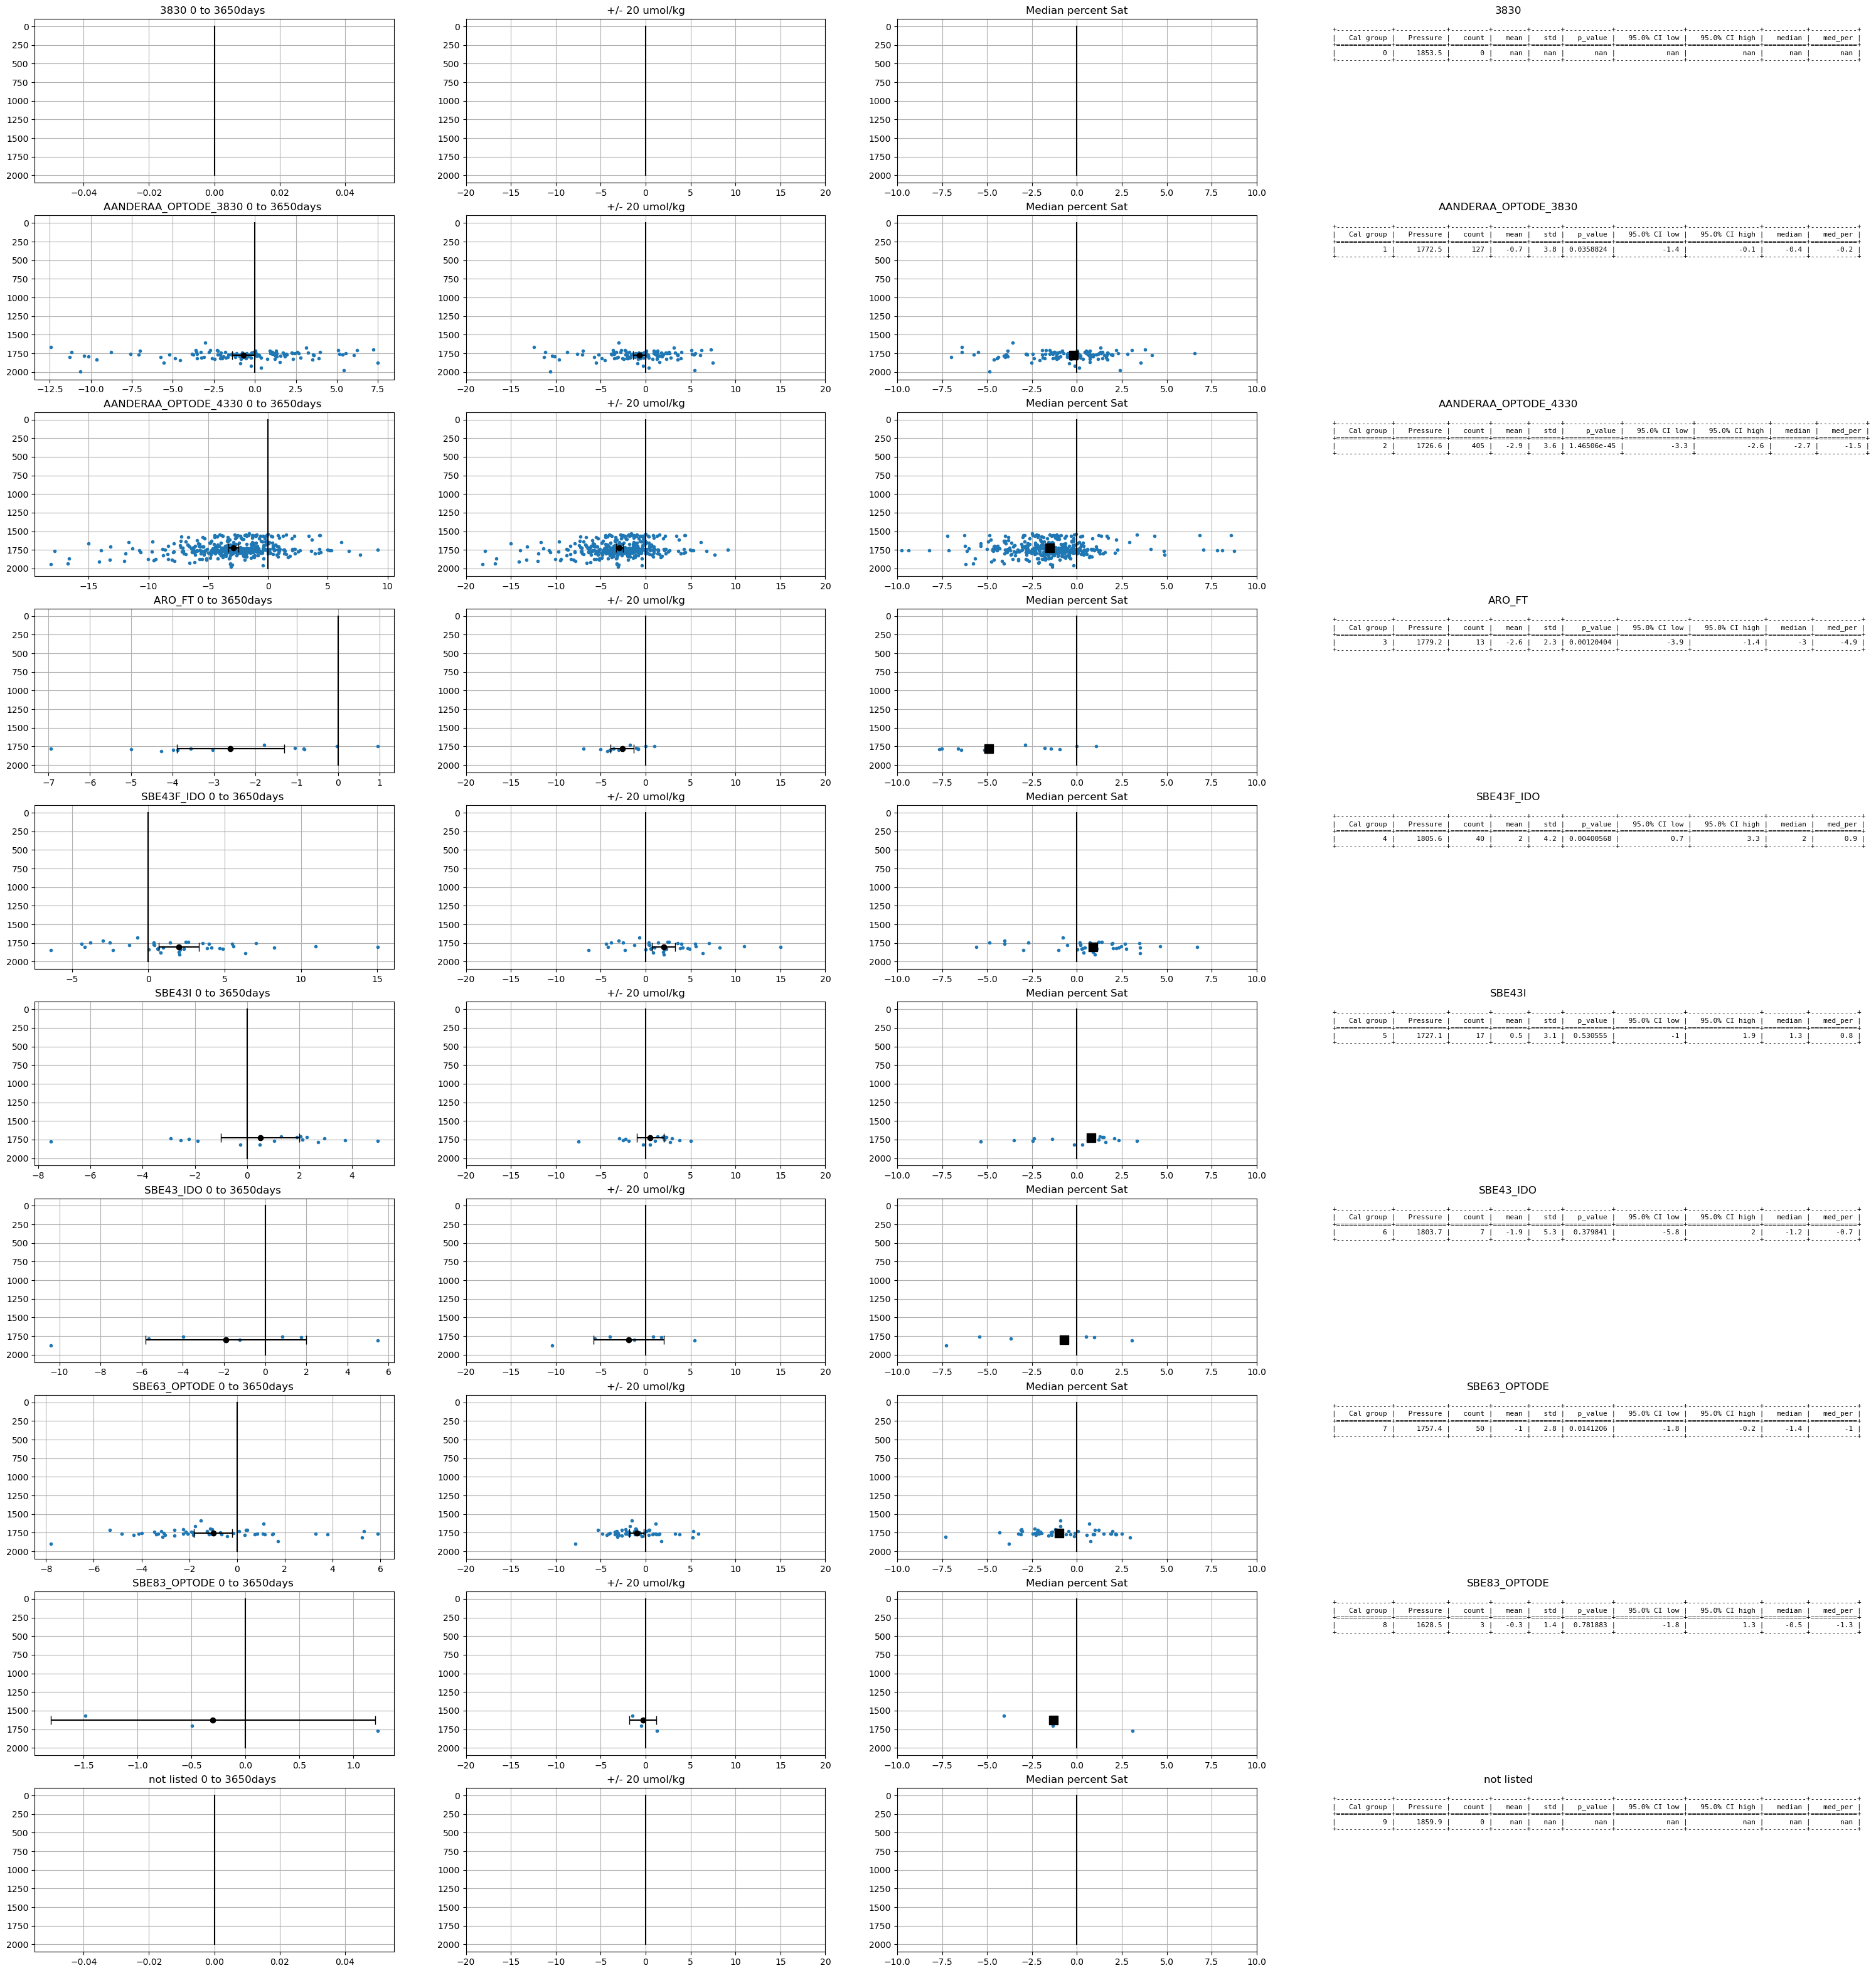

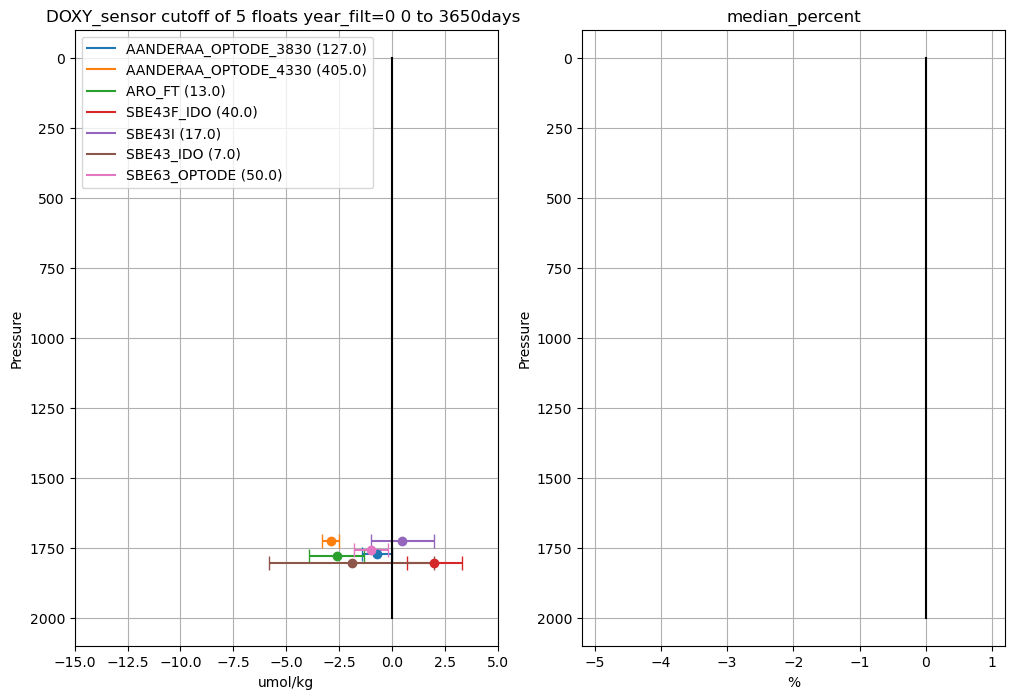

In [10]:
# # want to loop through and save out all pressure values for each type (cal_group) so that I can make some synthesis plots

# cal_groups_all  = [['All', 'air cal', 'no air cal'], o2_sensors, big_projects, data_centers]
# parameter_a_all= ['o2_calib_air_group', 'DOXY_sensor', 'project_name', 'data_centre']

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups = data_centers
# parameter_a = 'data_centre'

# cal_groups = ['All', 'air cal', 'no air cal']
# parameter_a = 'o2_calib_air_group'

# cal_groups = big_projects
# parameter_a = 'project_name'

cal_groups  = o2_sensors
parameter_a= 'DOXY_sensor' 

# cal_groups = data_centers
# parameter_a = 'data_centre'

CI_level = 0.95

float_age_filter = 1
# for n, cal_groups in enumerate(cal_groups_all):
#     parameter_a = parameter_a_all[n]

abs_lat_cutoff_shallow = 55

for fa in range(len(float_age_bins)-1):
    o2_offset_data_table = []

    fig = plt.figure(figsize=(34,len(cal_groups)*4))

    for filename in glodap_offsets_filenames:
        
        for j in range(len(pressure_levels)-1):
            try:
                dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
            except:
                continue   

            # if pressure levels are too shallow, remove data in high latitudes given issues with stratification
            if pressure_levels[j]<500:
                dataset_n = dataset_n.where(abs(dataset_n['main_float_latitude'])<abs_lat_cutoff_shallow)

              
            for idx, cal in enumerate(cal_groups):
                dataset_p = dataset_n.to_dataframe()
                offsets_o2_cal_group = dataset_p.groupby(parameter_a)
                # offsets_pH = dataset_p.groupby([parameter_a, parameter_b])

                if float_age_filter==0:
                    var = 'DOXY_ADJUSTED_offset_trimmed'
                else:
                    var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])
                    age_title = str(float_age_bins[fa]) + ' to ' + str(float_age_bins[fa+1]) + 'days '

                if np.logical_and(idx==0, parameter_a=='o2_calib_air_group'):
                    # print(idx)
                    # print(cal)
                    data_p = dataset_n[var].copy()
                    pressure_p = dataset_n.PRES_ADJUSTED_float
                    data_mag_p = dataset_n['DOXY_ADJUSTED_float'].copy()
                    if float_age_filter==1:
                        # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                        count_p = dataset_n[var + '_count']
                        data_p[count_p < 20] = np.nan

                else:
                    temp_dataset = offsets_o2_cal_group.get_group(cal)
                    data_p = temp_dataset[var].copy()
                    pressure_p = temp_dataset.PRES_ADJUSTED_float
                    data_mag_p = temp_dataset['DOXY_ADJUSTED_float'].copy()

                    if float_age_filter==1:
                        # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                        count_p = temp_dataset[var + '_count']
                        data_p[count_p < 20] = np.nan

            

                nmean = np.around(data_p.mean(), decimals=1)
                ncount = np.around(data_p.count(), decimals=1)
                nstd = np.around(data_p.std(), decimals=1)
                nmedian = np.around(data_p.median(), decimals=1)

                percent_sat_mag = data_p/data_mag_p*100
                nmedian_percent_mag = np.around(percent_sat_mag.median(), decimals=1)

                temp_var = data_p.copy()
                t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

                CI_vals = stats.norm.interval(confidence=CI_level, 
                                loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                                scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
                CI_low = np.around(CI_vals[0], decimals=1)
                CI_high = np.around(CI_vals[1], decimals=1)
                ax1 = plt.subplot(len(cal_groups),4,(1+4*idx))
                if float_age_filter==0:
                    plt.title(cal.strip() )
                else:
                    plt.title(cal.strip() + ' ' + age_title)
                plt.plot(data_p, pressure_p,'.')
                plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                plt.grid('on')
                ax2 = plt.subplot(len(cal_groups),4,(2+4*idx))
                plt.title('+/- 20 umol/kg')
                plt.plot(data_p, pressure_p,'.')
                plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                npres = np.around(pressure_p.mean(), decimals=1)
                plt.xlim([-20, 20])
                plt.grid('on')
                o2_offset_data_table.append((idx, npres, ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmedian_percent_mag))

                # plot offset in percent saturation
                ax2 = plt.subplot(len(cal_groups),4,(3+4*idx))
                plt.title('Median percent Sat')
                plt.plot(percent_sat_mag, pressure_p,'.')
                plt.plot(nmedian_percent_mag, pressure_p.mean(),'sk', markersize=10, linewidth=10)

                # plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                plt.xlim([-10, 10])
                plt.grid('on')

    for idx, cal in enumerate(cal_groups):
        plt.subplot(len(cal_groups),4,(1+4*idx))
        plt.gca().invert_yaxis()
        plt.plot([0,0], [0, 2000], 'k-')
        plt.subplot(len(cal_groups),4,(2+4*idx))
        plt.gca().invert_yaxis()
        plt.plot([0,0], [0, 2000], 'k-')

        plt.subplot(len(cal_groups),4,(3+4*idx))
        plt.gca().invert_yaxis()
        plt.plot([0,0], [0, 2000], 'k-')

    o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
    sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

    # base_value = 1
    # increment = 3
    # num_iterations = 10  

    # for idx in range(num_iterations):
    #     current_value = base_value + increment * idx
    #     print(f"Index: {idx}, Value: {current_value}")

    for idx, cal in enumerate(cal_groups):
        filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
        # Create a string buffer to store the table
        table_buffer = StringIO()

        # Convert the o2_offset_data_table to a table and write it to the buffer
        print(tabulate(filtered_data_table, 
                    headers=['Cal group', 'Pressure', 'count',
                                'mean', 'std', 'p_value', 
                                str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 
                                'median', 'med_per'], tablefmt='grid'), file=table_buffer)

        # Display the table in a subplot
        plt.subplot(len(cal_groups),4,(4+4*idx))
        plt.title(cal.strip())

        plt.axis('off')  # Turn off axis for the table
        # plt.text(0.01, 0.01, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
        plt.text(0.01, 0.95, table_buffer.getvalue(), va='top', ha='left', transform=plt.gca().transAxes, fontfamily='monospace', fontsize=8)
        
        # break

    plot_filename = var + '_vs_depth_grouped_' + parameter_a + '_year_filt_' + str(year_filt) +'_' + str(year_plus_minus)  + '_abs_Lat_cut_' + str(abs_lat_cutoff_shallow)
    plt.savefig(grouped_plot_dir + plot_filename + '.png', dpi=300)

    o2_offset_table_cal_groups = pd.DataFrame(columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count', 'per_med'])
    
    for idx, cal in enumerate(cal_groups):
        filtered_data_table = [row for row in sorted_data_table if row[0] == idx]

        for i in range(0,len(filtered_data_table)):
            new_data_o2_direct_impact = [(cal.strip(), 
                                        filtered_data_table[i][1], 
                                        filtered_data_table[i][3],
                                        filtered_data_table[i][6],
                                        filtered_data_table[i][7],
                                        filtered_data_table[i][2],
                                        filtered_data_table[i][9])]
            new_data_o2_direct_impact_df = pd.DataFrame(new_data_o2_direct_impact, columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count', 'per_med'])
            o2_offset_table_cal_groups = pd.concat([o2_offset_table_cal_groups, new_data_o2_direct_impact_df], ignore_index=True)

    if parameter_a=='project_name':
        n_cutoff= 10
        x_lim = [-25, 10]
    elif parameter_a=='DOXY_sensor':
        n_cutoff = 5
        x_lim = [-15, 5]
    elif parameter_a == 'o2_calib_air_group':
        n_cutoff = 0
        x_lim = [-10, 2.5]
    elif parameter_a == 'data_centre':
        n_cutoff = 5
        x_lim = [-22, 5]


    fig = plt.figure(figsize=(12,8))
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)

    for cal in cal_groups:
        temp_group = o2_offset_table_cal_groups[o2_offset_table_cal_groups['Cal group']==cal.strip()]

        if temp_group.n_count.values.mean()<n_cutoff:
            continue

        line, = ax1.plot(temp_group.offset, temp_group.pressure, label=cal.strip() + ' (' + str(temp_group.n_count.values.mean()) + ')')
        line, = ax2.plot(temp_group.per_med, temp_group.pressure, label=cal.strip() + ' (' + str(temp_group.n_count.values.mean()) + ')')

        line_color = line.get_color()
        for i in range(0,len(temp_group)):
            ax1.errorbar(temp_group.offset.values[i], temp_group.pressure.values[i], xerr=temp_group.offset.values[i]-temp_group.CI_low.values[i],
                        fmt='o', capsize=5, color=line_color)

    ax1.invert_yaxis()
    ax2.invert_yaxis()

    ax1.plot([0,0], [0, 2000], 'k-')
    ax2.plot([0,0], [0, 2000], 'k-')

    ax1.grid('on')
    ax2.grid('on')

    ax1.set_xlim(x_lim)
    ax1.legend()
    if float_age_filter==0:
        ax1.set_title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt))

    else:
        ax1.set_title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt) + ' ' + age_title)
    ax2.set_title('median_percent')

    ax1.set_xlabel('umol/kg')
    ax2.set_xlabel('%')

    ax1.set_ylabel('Pressure')
    ax2.set_ylabel('Pressure')

    plot_filename = var + 'Offsets_vs_depth_grouped_' + parameter_a + '_year_filt' + str(year_filt) +'_' + str(year_plus_minus) + '_all_cutoff_' + str(n_cutoff)  + '_abs_Lat_cut_' + str(abs_lat_cutoff_shallow)
    fig.savefig(grouped_plot_dir  + plot_filename + '.png', dpi=600)

    
    if float_age_filter==0:
        break

    


### Plotting multiple groupings of parameters

In [34]:
len(dataset_2_filter['o2_calib_comment'])

123

In [36]:
# trying to find the one SBE63 with air cal so I can check it 
dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
# cal_a = cal_groups_a[0] # air cal 
cal_a = cal_groups_a[1] # no air cal 

cal_a
dataset_1_filter = dataset_n.where(dataset_n[parameter_a]==cal_a, drop=True)
dataset_1_filter
# cal_b = cal_groups_b[7] # SBE 63
cal_b = cal_groups_b[2] # 4330
cal_b = cal_groups_b[1] # 4330

print(cal_b)
dataset_2_filter = dataset_n.where(dataset_1_filter[parameter_b]==cal_b, drop=True)
for i in range(0, len(dataset_2_filter['o2_calib_comment'])):
    print(dataset_2_filter['o2_calib_comment'][i].values)


AANDERAA_OPTODE_3830                                                                                                                                                                                                                                            
DOXY_ADJUSTED computed using Stern-Volmer equation with coeffs refit from foil calibration data & WOD data as in Drucker & Riser (2016). The quoted error was computed via comparisons with WOA09 data, interpolated to float location, depth, and season.      
Adjusted with WOA climatology, optode simple calibration                                                                                                                                                                                                        
Percent saturation corrected as a linear function of PSAT modified from Takeshita et al (2013); PSAT converted from DOXY and DOXY_ADJUSTED converted from PSAT_ADJUSTED; oxygen corrected as a linear function of DOXY by comparison 

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: Run

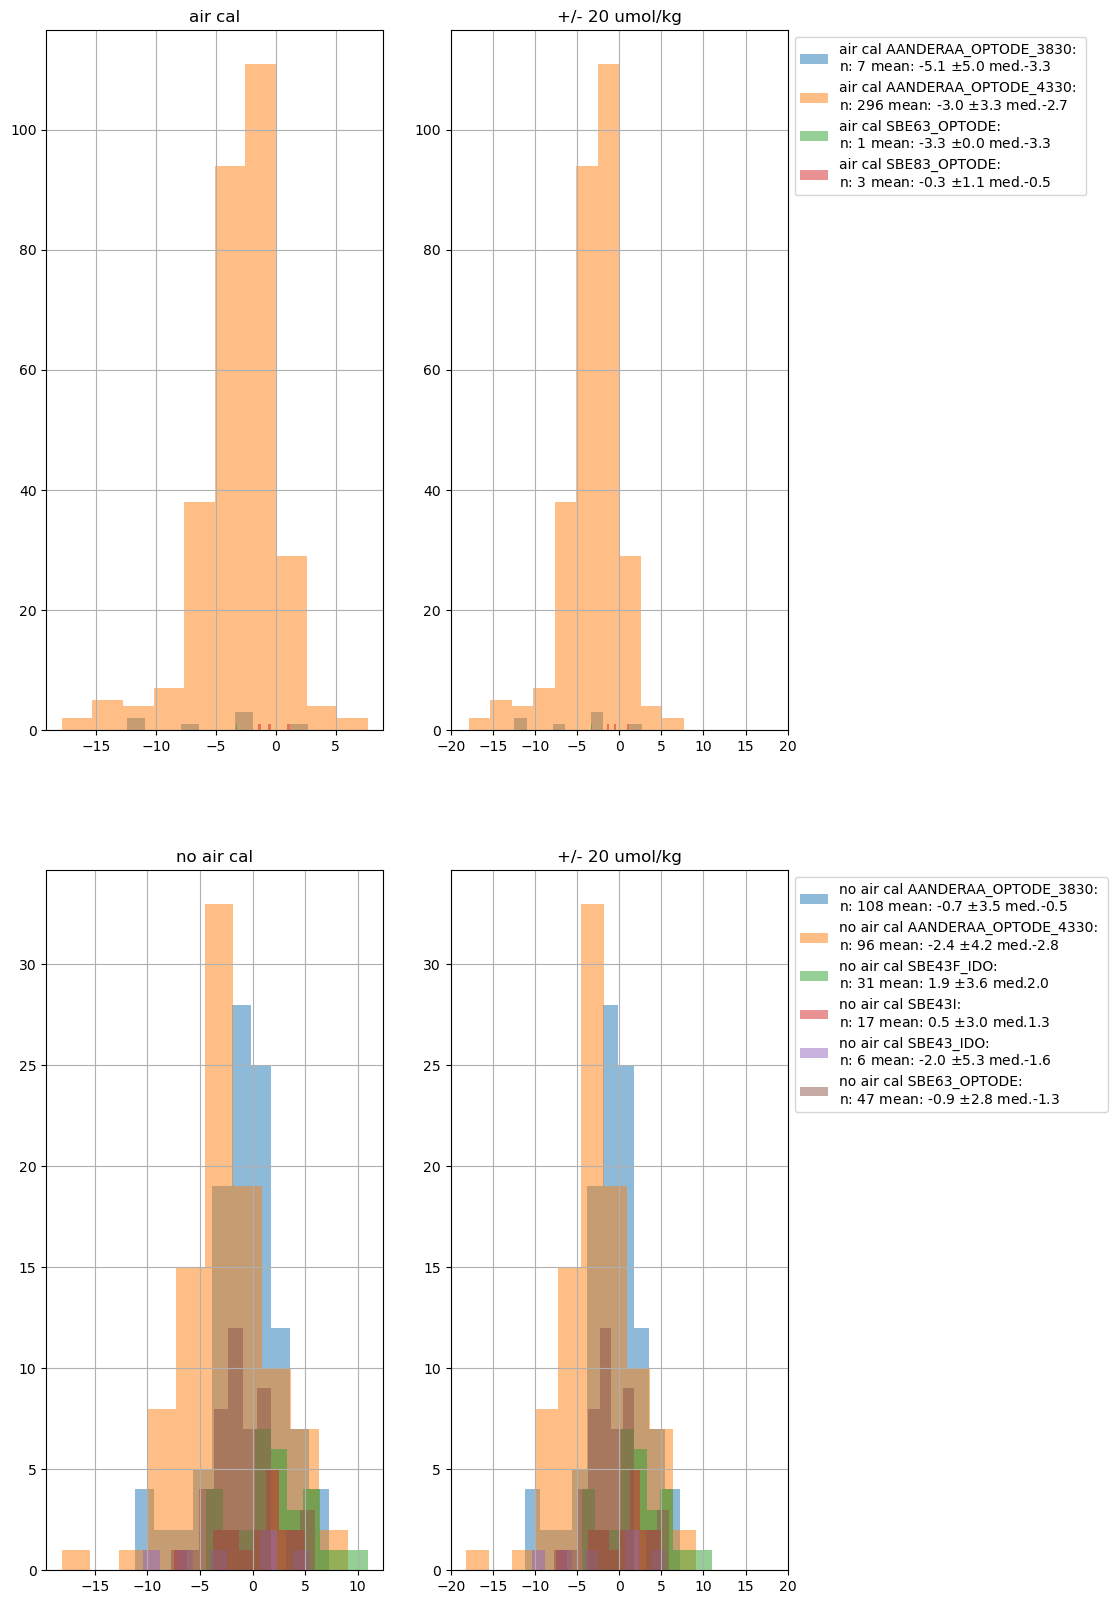

In [11]:
# # multiple groupings of parameters

# cal_groups_all  = [['All', 'air cal', 'no air cal'], o2_sensors, big_projects, data_centers]
# parameter_a_all= ['o2_calib_air_group', 'DOXY_sensor', 'project_name', 'data_centre']

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups = data_centers
# parameter_a = 'data_centre'



# cal_groups = big_projects
# parameter_a = 'project_name'

cal_groups_b  = o2_sensors
parameter_b= 'DOXY_sensor' 

cal_groups_a = ['air cal', 'no air cal']
parameter_a = 'o2_calib_air_group'


# cal_groups = data_centers
# parameter_a = 'data_centre'

CI_level = 0.95

float_age_filter = 0
# for n, cal_groups in enumerate(cal_groups_all):
#     parameter_a = parameter_a_all[n]

abs_lat_cutoff_shallow = 55


# AA = dataset_n.where(dataset_n['o2_calib_air_group']=='air cal', drop=True)
# BB = AA.where(AA['DOXY_sensor']==o2_sensors[1], drop=True)

for fa in range(len(float_age_bins)-1):
    o2_offset_data_table = []

    fig = plt.figure(figsize=(20,len(cal_groups_a)*10))

    for filename in glodap_offsets_filenames:
        
        for j in range(len(pressure_levels)-1):
            try:
                dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
            except:
                continue   

            # if pressure levels are too shallow, remove data in high latitudes given issues with stratification
            if pressure_levels[j]<500:
                dataset_n = dataset_n.where(abs(dataset_n['main_float_latitude'])<abs_lat_cutoff_shallow)

              
            for idx, cal_a in enumerate(cal_groups_a):
                dataset_1_filter = dataset_n.where(dataset_n[parameter_a]==cal_a, drop=True)

                for idx2, cal_b in enumerate(cal_groups_b):
                    dataset_2_filter = dataset_n.where(dataset_1_filter[parameter_b]==cal_b, drop=True)

                    if float_age_filter==0:
                        var = 'DOXY_ADJUSTED_offset_trimmed'
                    else:
                        var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])
                        age_title = str(float_age_bins[fa]) + ' to ' + str(float_age_bins[fa+1]) + 'days '



                    nmean = np.around(dataset_2_filter[var].mean().values, decimals=1)
                    ncount = np.around(dataset_2_filter[var].count().values, decimals=1)
                    nstd = np.around(dataset_2_filter[var].std().values, decimals=1)
                    nmedian = np.around(dataset_2_filter[var].median().values, decimals=1)

                    percent_sat_mag = data_p/data_mag_p*100
                    nmedian_percent_mag = np.around(percent_sat_mag.median(), decimals=1)

                    # temp_var = dataset_2_filter.copy()
                    # t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

                    # CI_vals = stats.norm.interval(confidence=CI_level, 
                    #                 loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                    #                 scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
                    # CI_low = np.around(CI_vals[0], decimals=1)
                    # CI_high = np.around(CI_vals[1], decimals=1)
                    ax1 = plt.subplot(len(cal_groups_a),4,(1+4*idx))
                    if float_age_filter==0:
                        plt.title(cal_a.strip())
                    else:
                        plt.title(cal.strip() + ' ' + age_title)
                    # plt.plot(data_p, pressure_p,'.')
                    # plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                    if np.sum(~np.isnan(dataset_2_filter[var].values))==0:
                        continue
                    plt.hist(dataset_2_filter[var], alpha=0.5, 
                             label=cal_a.strip() + ' ' + cal_b.strip() + ': \nn: '+str(ncount) +  ' mean: ' + str(nmean) + ' $\pm$' + str(nstd) + ' med.' + str(nmedian))

                    plt.grid('on')
                    ax2 = plt.subplot(len(cal_groups_a),4,(2+4*idx))
                    plt.title('+/- 20 umol/kg')
                    # plt.plot(data_p, pressure_p,'.')
                    # plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')
                    plt.hist(dataset_2_filter[var], alpha=0.5,
                             label=cal_a.strip() + ' ' + cal_b.strip() + ': \nn: '+str(ncount) +  ' mean: ' + str(nmean) + ' $\pm$' + str(nstd)+ ' med.' + str(nmedian))

                    # npres = np.around(pressure_p.mean(), decimals=1)
                    plt.xlim([-20, 20])
                    plt.grid('on')
                    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

                    # o2_offset_data_table.append((idx, npres, ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmedian_percent_mag))

                    # plot offset in percent saturation
                    # ax2 = plt.subplot(len(cal_groups),4,(3+4*idx))
                    # plt.title('Median percent Sat')
                    # plt.plot(percent_sat_mag, pressure_p,'.')
                    # plt.plot(nmedian_percent_mag, pressure_p.mean(),'sk', markersize=10, linewidth=10)

                    # plt.errorbar(nmean, pressure_p.mean(), xerr=nmean-CI_low, fmt='o', capsize=5,color='k')

                    # plt.xlim([-10, 10])
                    # plt.grid('on')
                
            break
        break
    plot_filename = var + 'Offsets_grouped_by_' + parameter_a + ' ' + parameter_b
    fig.savefig(grouped_plot_dir  + plot_filename + '.png', dpi=600)

    break

    #             dataset_p = dataset_n.to_dataframe()
    #             offsets_o2_cal_group = dataset_p.groupby(parameter_a)
    #             # offsets_pH = dataset_p.groupby([parameter_a, parameter_b])

    #             if float_age_filter==0:
    #                 var = 'DOXY_ADJUSTED_offset_trimmed'
    #             else:
    #                 var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])
    #                 age_title = str(float_age_bins[fa]) + ' to ' + str(float_age_bins[fa+1]) + 'days '

    #             if np.logical_and(idx==0, parameter_a=='o2_calib_air_group'):
    #                 # print(idx)
    #                 # print(cal)
    #                 data_p = dataset_n[var].copy()
    #                 pressure_p = dataset_n.PRES_ADJUSTED_float
    #                 data_mag_p = dataset_n['DOXY_ADJUSTED_float'].copy()
    #                 if float_age_filter==1:
    #                     # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
    #                     count_p = dataset_n[var + '_count']
    #                     data_p[count_p < 20] = np.nan

    #             else:
    #                 temp_dataset = offsets_o2_cal_group.get_group(cal)
    #                 data_p = temp_dataset[var].copy()
    #                 pressure_p = temp_dataset.PRES_ADJUSTED_float
    #                 data_mag_p = temp_dataset['DOXY_ADJUSTED_float'].copy()

    #                 if float_age_filter==1:
    #                     # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
    #                     count_p = temp_dataset[var + '_count']
    #                     data_p[count_p < 20] = np.nan

            

    #             

    # for idx, cal in enumerate(cal_groups):
    #     plt.subplot(len(cal_groups),4,(1+4*idx))
    #     plt.gca().invert_yaxis()
    #     plt.plot([0,0], [0, 2000], 'k-')
    #     plt.subplot(len(cal_groups),4,(2+4*idx))
    #     plt.gca().invert_yaxis()
    #     plt.plot([0,0], [0, 2000], 'k-')

    #     plt.subplot(len(cal_groups),4,(3+4*idx))
    #     plt.gca().invert_yaxis()
    #     plt.plot([0,0], [0, 2000], 'k-')

    # o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
    # sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

    # # base_value = 1
    # # increment = 3
    # # num_iterations = 10  

    # # for idx in range(num_iterations):
    # #     current_value = base_value + increment * idx
    # #     print(f"Index: {idx}, Value: {current_value}")

    # for idx, cal in enumerate(cal_groups):
    #     filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
    #     # Create a string buffer to store the table
    #     table_buffer = StringIO()

    #     # Convert the o2_offset_data_table to a table and write it to the buffer
    #     print(tabulate(filtered_data_table, 
    #                 headers=['Cal group', 'Pressure', 'count',
    #                             'mean', 'std', 'p_value', 
    #                             str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 
    #                             'median', 'med_per'], tablefmt='grid'), file=table_buffer)

    #     # Display the table in a subplot
    #     plt.subplot(len(cal_groups),4,(4+4*idx))
    #     plt.title(cal.strip())

    #     plt.axis('off')  # Turn off axis for the table
    #     # plt.text(0.01, 0.01, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
    #     plt.text(0.01, 0.95, table_buffer.getvalue(), va='top', ha='left', transform=plt.gca().transAxes, fontfamily='monospace', fontsize=8)
        
    #     # break

    # plot_filename = var + '_vs_depth_grouped_' + parameter_a + '_year_filt_' + str(year_filt) +'_' + str(year_plus_minus)  + '_abs_Lat_cut_' + str(abs_lat_cutoff_shallow)
    # plt.savefig(grouped_plot_dir + plot_filename + '.png', dpi=300)

    # o2_offset_table_cal_groups = pd.DataFrame(columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count', 'per_med'])
    
    # for idx, cal in enumerate(cal_groups):
    #     filtered_data_table = [row for row in sorted_data_table if row[0] == idx]

    #     for i in range(0,len(filtered_data_table)):
    #         new_data_o2_direct_impact = [(cal.strip(), 
    #                                     filtered_data_table[i][1], 
    #                                     filtered_data_table[i][3],
    #                                     filtered_data_table[i][6],
    #                                     filtered_data_table[i][7],
    #                                     filtered_data_table[i][2],
    #                                     filtered_data_table[i][9])]
    #         new_data_o2_direct_impact_df = pd.DataFrame(new_data_o2_direct_impact, columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count', 'per_med'])
    #         o2_offset_table_cal_groups = pd.concat([o2_offset_table_cal_groups, new_data_o2_direct_impact_df], ignore_index=True)

    # if parameter_a=='project_name':
    #     n_cutoff= 10
    #     x_lim = [-25, 10]
    # elif parameter_a=='DOXY_sensor':
    #     n_cutoff = 5
    #     x_lim = [-15, 5]
    # elif parameter_a == 'o2_calib_air_group':
    #     n_cutoff = 0
    #     x_lim = [-10, 2.5]
    # elif parameter_a == 'data_centre':
    #     n_cutoff = 5
    #     x_lim = [-22, 5]


    # fig = plt.figure(figsize=(12,8))
    # ax1 = plt.subplot(1,2,1)
    # ax2 = plt.subplot(1,2,2)

    # for cal in cal_groups:
    #     temp_group = o2_offset_table_cal_groups[o2_offset_table_cal_groups['Cal group']==cal.strip()]

    #     if temp_group.n_count.values.mean()<n_cutoff:
    #         continue

    #     line, = ax1.plot(temp_group.offset, temp_group.pressure, label=cal.strip() + ' (' + str(temp_group.n_count.values.mean()) + ')')
    #     line, = ax2.plot(temp_group.per_med, temp_group.pressure, label=cal.strip() + ' (' + str(temp_group.n_count.values.mean()) + ')')

    #     line_color = line.get_color()
    #     for i in range(0,len(temp_group)):
    #         ax1.errorbar(temp_group.offset.values[i], temp_group.pressure.values[i], xerr=temp_group.offset.values[i]-temp_group.CI_low.values[i],
    #                     fmt='o', capsize=5, color=line_color)

    # ax1.invert_yaxis()
    # ax2.invert_yaxis()

    # ax1.plot([0,0], [0, 2000], 'k-')
    # ax2.plot([0,0], [0, 2000], 'k-')

    # ax1.grid('on')
    # ax2.grid('on')

    # ax1.set_xlim(x_lim)
    # ax1.legend()
    # if float_age_filter==0:
    #     ax1.set_title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt))

    # else:
    #     ax1.set_title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt) + ' ' + age_title)
    # ax2.set_title('median_percent')

    # ax1.set_xlabel('umol/kg')
    # ax2.set_xlabel('%')

    # ax1.set_ylabel('Pressure')
    # ax2.set_ylabel('Pressure')

    # plot_filename = var + 'Offsets_vs_depth_grouped_' + parameter_a + '_year_filt' + str(year_filt) +'_' + str(year_plus_minus) + '_all_cutoff_' + str(n_cutoff)  + '_abs_Lat_cut_' + str(abs_lat_cutoff_shallow)
    # fig.savefig(grouped_plot_dir  + plot_filename + '.png', dpi=600)

    
    # if float_age_filter==0:
    #     break

    


In [67]:
sorted_data_table

[(0,
  <xarray.DataArray 'PRES_ADJUSTED_float' ()>
  array(59.9),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(230),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(-5.2),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(11.3),
  2.8099771664959656e-11,
  -6.7,
  -3.8,
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(-4.2),
  <xarray.DataArray ()>
  array(-1.7)),
 (0,
  <xarray.DataArray 'PRES_ADJUSTED_float' ()>
  array(149.4),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(241),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(-6.4),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(10.4),
  4.042091156341461e-18,
  -7.7,
  -5.0,
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(-4.7),
  <xarray.DataArray ()>
  array(-2.9)),
 (0,
  <xarray.DataArray 'PRES_ADJUSTED_float' ()>
  array(250.2),
  <xarray.DataArray 'DOXY_ADJUSTED_offset_age_0' ()>
  array(215),
  <xarray.DataArray 'DOXY_AD

3830                                                                                                                                                                                                                                                            
AANDERAA_OPTODE_3830                                                                                                                                                                                                                                            
AANDERAA_OPTODE_4330                                                                                                                                                                                                                                            
ARO_FT                                                                                                                                                                                                                               

/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/smb-uh/opt/anaconda3/envs/float_oxygen_offset_impacts/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


AO
CS
IF
IN
JA
ME


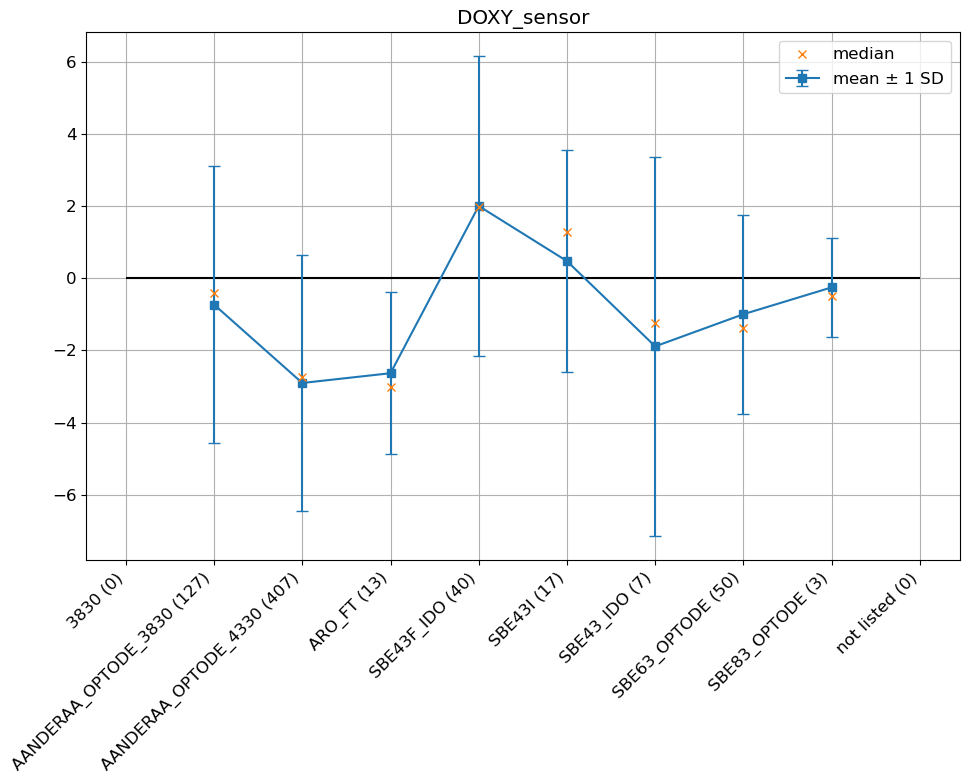

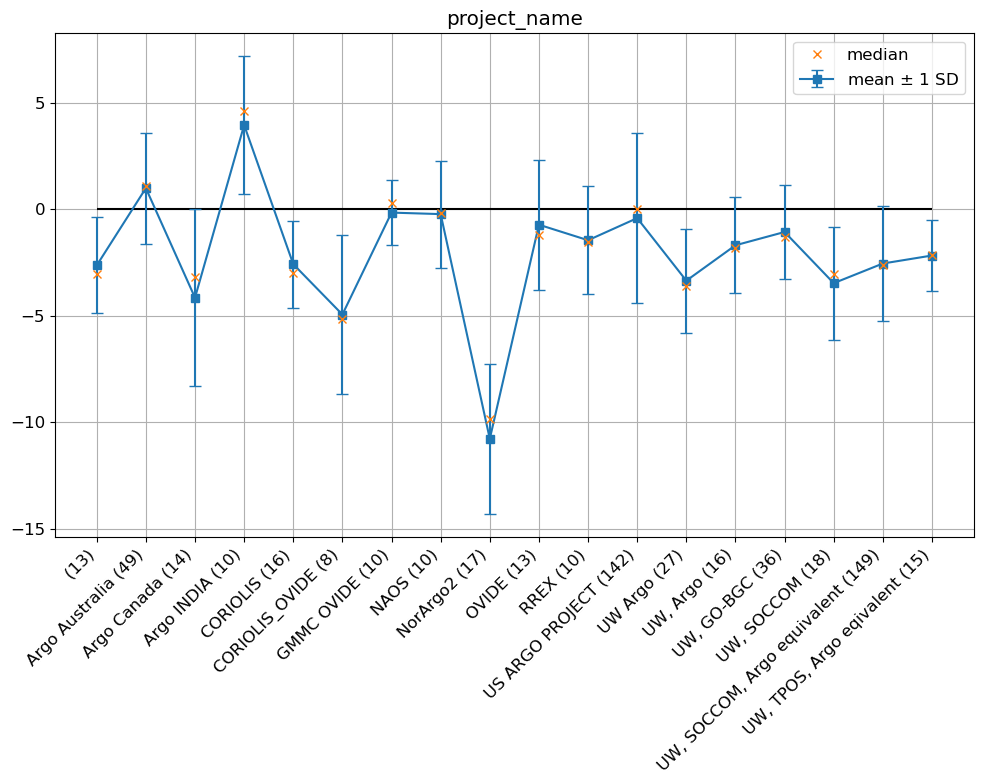

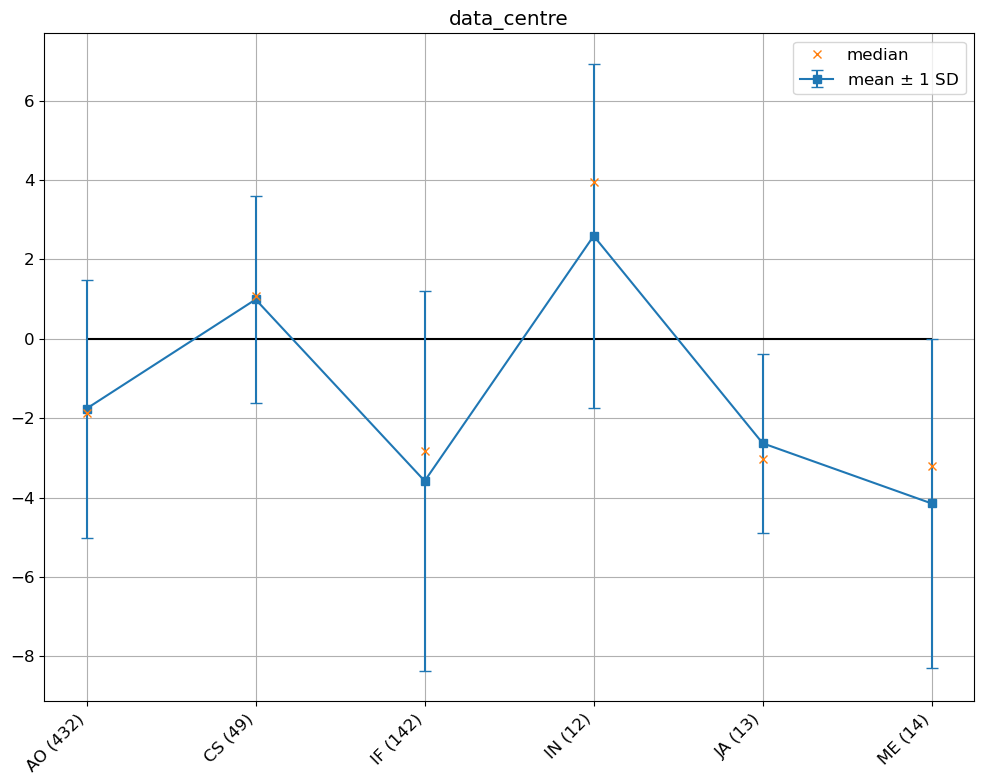

In [15]:
# plots of means, SDs, and medians for various groupings 
cal_groups_all  = [o2_sensors, big_projects, data_centers]
parameter_a_all= ['DOXY_sensor', 'project_name', 'data_centre']

# cal_groups = big_projects
# parameter_a = 'project_name'

# cal_groups = data_centers
# parameter_a = 'data_centre'
for n, cal_groups in enumerate(cal_groups_all):
    parameter_a = parameter_a_all[n]
    cal_group_labels = []
    for fa in range(len(float_age_bins)-1):
        o2_offset_data_table = []
        means = []
        stds = []
        medians = []
        counts = []

        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(1,1,1)
        for filename in glodap_offsets_filenames:
            
            for j in range(len(pressure_levels)-1):
                try:
                    dataset_n = mean_gdap_offsets[filename][f'level_{pressure_levels[j]}']
                except:
                    continue    
                for idx, cal in enumerate(cal_groups):
                    dataset_p = dataset_n.to_dataframe()
                    offsets_o2_cal_group = dataset_p.groupby(parameter_a)
                    if float_age_filter==0:
                        var = 'DOXY_ADJUSTED_offset_trimmed'
                    else:
                        var = 'DOXY_ADJUSTED_offset_' + 'age_' + str(float_age_bins[fa])

                    if np.logical_and(idx==0, parameter_a=='o2_calib_air_group'):
                        # print(idx)
                        # print(cal)
                        data_p = dataset_n[var].copy()
                        pressure_p = dataset_n.PRES_ADJUSTED_float

                        if float_age_filter==1:
                            # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                            count_p = dataset_n[var + '_count']
                            data_p[count_p < 20] = np.nan
                    else:
                        temp_dataset = offsets_o2_cal_group.get_group(cal)
                        data_p = temp_dataset[var].copy()
                        pressure_p = temp_dataset.PRES_ADJUSTED_float

                        if float_age_filter==1:
                            # remove data with too few points if looking at float age - otherwise it already happened during the pressure level filtering
                            count_p = temp_dataset[var + '_count']
                            data_p[count_p < 20] = np.nan
                        print(cal)
                    # nmean = np.around(data_p.mean(), decimals=1)
                    # ncount = np.around(data_p.count(), decimals=1)
                    # nstd = np.around(data_p.std(), decimals=1)
                    # nmedian = np.around(data_p.median(), decimals=1)
                    cal_group_labels.append(cal.strip() + ' (' + str(data_p.count())+ ')')

                    means.append(data_p.mean())
                    stds.append(data_p.std())
                    counts.append(data_p.count())
                    medians.append(data_p.median())

        x = np.arange(len(cal_group_labels))

        plt.hlines(0, xmin=0, xmax=len(cal_group_labels)-1, colors='k')
        plt.grid('on')
        # plt.plot(x, means, 's', label='mean')
        plt.errorbar(x, means, yerr=stds, marker='s', label='mean $\pm$ 1 SD', capsize=4)
        plt.plot(x, medians, 'x', label='median', zorder=4, linewidth=4)

        ax.set_xticks(x, labels=cal_group_labels, rotation=45, ha='right')
        # ax.set_xticklabels(cal_group_labels, rotation=45, ha='right')
        ax.set_title(parameter_a)
        ax.legend()
        plt.tight_layout()
        plot_filename = var + '_means_' + parameter_a + '_year_filt_' + str(year_filt) +'_' + str(year_plus_minus)

        plt.savefig(grouped_plot_dir + plot_filename + '.png')
    
            
        

In [ ]:

o2_offset_table_cal_groups = pd.DataFrame(columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count'])
for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]

    for i in range(0,len(filtered_data_table)):
        new_data_o2_direct_impact = [(cal.strip(), 
                                      filtered_data_table[i][1], 
                                      filtered_data_table[i][3],
                                      filtered_data_table[i][6],
                                      filtered_data_table[i][7],
                                      filtered_data_table[i][2])]
        new_data_o2_direct_impact_df = pd.DataFrame(new_data_o2_direct_impact, columns=['Cal group','pressure','offset', 'CI_low', 'CI_high', 'n_count'])
        o2_offset_table_cal_groups = pd.concat([o2_offset_table_cal_groups, new_data_o2_direct_impact_df], ignore_index=True)

if parameter_a=='project_name':
    n_cutoff= 30
    x_lim = [-25, 10]
elif parameter_a=='DOXY_sensor':
    n_cutoff = 20
    x_lim = [-15, 5]
elif parameter_a == 'o2_calib_air_group':
    n_cutoff = 0
    x_lim = [-10, 2.5]
elif parameter_a == 'data_centre':
    n_cutoff = 30
    x_lim = [-22, 5]


fig = plt.figure(figsize=(8,8))

for cal in cal_groups:
    temp_group = o2_offset_table_cal_groups[o2_offset_table_cal_groups['Cal group']==cal.strip()]

    if temp_group.n_count.values.mean()<n_cutoff:
        continue

    line, = plt.plot(temp_group.offset, temp_group.pressure, label=cal.strip())
    
    line_color = line.get_color()
    for i in range(0,len(temp_group)):
        plt.errorbar(temp_group.offset.values[i], temp_group.pressure.values[i], xerr=temp_group.offset.values[i]-temp_group.CI_low.values[i],
                      fmt='o', capsize=5, color=line_color)

plt.gca().invert_yaxis()
plt.plot([0,0], [0, 2000], 'k-')
plt.grid('on')
plt.xlim(x_lim)
plt.legend()
plt.title(parameter_a + ' cutoff of ' + str(n_cutoff) + ' floats' + ' year_filt=' + str(year_filt))
plt.xlabel('umol/kg')
plt.ylabel('Pressure')
plot_filename = 'Offsets_vs_depth_grouped_' + parameter_a + '_year_filt' + str(year_filt) +'_' + str(year_plus_minus) + '_all_cutoff_' + str(n_cutoff)
plt.savefig(grouped_plot_dir  + plot_filename + '.png')

In [ ]:
gdap_offsets[filename]['level_1500'].main_float_wmo=='5903615'

In [ ]:
filtered_data_table

In [ ]:
# Filter out rows with nan values in the first element
o2_offset_data_table = [row for row in o2_offset_data_table if not np.isnan(row[1])]
sorted_data_table = sorted(o2_offset_data_table, key=lambda x: x[0])

# base_value = 1
# increment = 3
# num_iterations = 10  # You can adjust this based on the number of iterations you need

# for idx in range(num_iterations):
#     current_value = base_value + increment * idx
#     print(f"Index: {idx}, Value: {current_value}")

for idx, cal in enumerate(cal_groups):
    filtered_data_table = [row for row in sorted_data_table if row[0] == idx]
    # print(cal)
    # print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))
    # Create a string buffer to store the table
    table_buffer = StringIO()

    # Convert the o2_offset_data_table to a table and write it to the buffer
    print(tabulate(filtered_data_table, headers=['Cal group', 'Pressure', 'count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median'], tablefmt='grid'), file=table_buffer)

    # Display the table in a subplot
    plt.subplot(len(cal_groups),3,(1+3*idx))
    plt.axis('off')  # Turn off axis for the table
    plt.text(0.1, 0.1, table_buffer.getvalue(), va='top', ha='left', fontfamily='monospace', fontsize=8)
    # break